# **Time Series Analysis of Microsoft Stock (2018 - 2025)**

## **Workflow of the Project**

<ul>
    <li>Data Collection and Loading</li>
    <li>Exploratory Data Analysis (E.D.A.)</li>
    <li>Feature Engineering</li>
    <li>Data Preprocessing</li>
    <li>Traditional Vs Non-Traditional Model Developments</li>
    <li>Model Evaluation</li>
    <li>Conclusion</li>
</ul>

### Importing the Dependencies

In [4]:
#%pip install arch statsmodels
#%pip install ta

In [306]:
# Print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Library for Warning Message
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*no associated frequency information.*")
warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed to converge.*")

# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Traditional Time Series Model Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import ta
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model

# Advance Model Libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.inspection import permutation_importance

# Performance Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Data Collection and Loading

In [7]:
# Data Collection Source --> "https://macrotrends.net/stocks/charts/MSFT/microsoft/stock-price-history"

# Data Loading
msft_df = pd.read_csv("microsoft_stock_data.csv", parse_dates = ["date"])

### Temporary Functions

In [200]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_and_report(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{label} MSE: {mse: .2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    return mse, rmse, mape

# Create Sequence for Deep Learning Model
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create sequences and target
def create_multifeature_sequences(data, target_index, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i, target_index])  # target is next day's Close
    return np.array(X), np.array(y)

def permutation_feature_importance(model, X, y, baseline_rmse, feature_names):
    """
    X: shape (samples, time_steps, features)
    y: true target values (already inverse-transformed)
    baseline_rmse: RMSE of the model on the original data
    feature_names: list of feature names in order
    """
    results = []
    X_permuted = np.copy(X)

    for f_idx, feature in tqdm(enumerate(feature_names), total=len(feature_names)):
        # Shuffle feature across all samples and all time steps
        original_feature = X_permuted[:, :, f_idx].copy()
        for t in range(X.shape[1]):
            np.random.shuffle(X_permuted[:, t, f_idx])
        
        # Predict with shuffled feature
        y_pred = model.predict(X_permuted)
        y_pred_inv = inverse_transform_predictions(y_pred, target_index, scaler, X.shape[2])
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_inv))

        # Compute importance
        drop = rmse - baseline_rmse
        results.append((feature, drop))

        # Restore feature
        X_permuted[:, :, f_idx] = original_feature

    return sorted(results, key=lambda x: x[1], reverse=True)

def inverse_transform_predictions(pred_scaled, target_idx, scaler, total_features):
    padded = np.concatenate([
        np.zeros((len(pred_scaled), target_idx)),
        pred_scaled,
        np.zeros((len(pred_scaled), total_features - target_idx - 1))
    ], axis=1)
    return scaler.inverse_transform(padded)[:, target_idx]

### Exploratory Data Analysis (E.D.A.)

In [11]:
# Glimpse of the first 5 rows
print("Glimpse of the first 5 rows")
print(" ")
msft_df.head()

Glimpse of the first 5 rows
 


,date,open,high,low,close,volume
0,1986-03-13,0.0543,0.0623,0.0543,0.0596,2196738
1,1986-03-14,0.0596,0.0627,0.0596,0.0617,655601
2,1986-03-17,0.0618,0.0634,0.0618,0.0628,283581
3,1986-03-18,0.0628,0.0633,0.0607,0.0612,144292
4,1986-03-19,0.0611,0.0617,0.0595,0.0601,101882


In [12]:
# Dimension of Data
print("Microsoft Stock data has {} rows and {} columns.".format(msft_df.shape[0], msft_df.shape[1]))

Microsoft Stock data has 9895 rows and 6 columns.


In [13]:
# Beginning and Ending Date
print("Start Date: {}".format(msft_df.date.min()))
print(" ")
print("End Date: {}".format(msft_df.date.max()))

Start Date: 1986-03-13 00:00:00
 
End Date: 2025-06-20 00:00:00


In [14]:
# Setting 'date' column to index
msft_df = msft_df.set_index("date")

msft_df.head()

,open,high,low,close,volume
date,,,,,
1986-03-13,0.0543,0.0623,0.0543,0.0596,2196738
1986-03-14,0.0596,0.0627,0.0596,0.0617,655601
1986-03-17,0.0618,0.0634,0.0618,0.0628,283581
1986-03-18,0.0628,0.0633,0.0607,0.0612,144292
1986-03-19,0.0611,0.0617,0.0595,0.0601,101882


Since trading does not occur on weekends and public holidays, those dates are excluded from the data. To ensure that all calendar days are represented, we will add the missing dates and fill the gaps using the previous day's closing price.

In [16]:
# Adding missing dates
all_dates = pd.date_range(start = msft_df.index.min(), end = msft_df.index.max(), freq = "D")
msft_df = msft_df.reindex(all_dates)

# Verify
nan = msft_df.isna().any(axis=1)
nan[nan == True]

1986-03-15    True
1986-03-16    True
1986-03-22    True
1986-03-23    True
1986-03-28    True
              ... 
2025-06-07    True
2025-06-08    True
2025-06-14    True
2025-06-15    True
2025-06-19    True
Length: 4450, dtype: bool

Since we're only interested in the "close" column, we'll drop all other columns from the dataset.

In [18]:
# Keep the required columns only
msft_df = msft_df[["close"]].round(2)

msft_df["close"] = msft_df["close"].ffill()

# Glimpse of the data
msft_df.head(14)

,close
1986-03-13,0.06
1986-03-14,0.06
1986-03-15,0.06
1986-03-16,0.06
1986-03-17,0.06
1986-03-18,0.06
1986-03-19,0.06
1986-03-20,0.06
1986-03-21,0.06
1986-03-22,0.06


This dataset contains records spanning from 1986 to 2025. For our analysis, we will retain only the data from the years 2018 to 2025, as these are the years relevant to our analysis.

In [20]:
# Slicing the data from 2018 - 2025
msft_df = msft_df.loc["2018" : ]

# Glimpse of the Data
msft_df.head(10)

,close
2018-01-01,78.95
2018-01-02,79.33
2018-01-03,79.70
2018-01-04,80.40
2018-01-05,81.40
2018-01-06,81.40
2018-01-07,81.40
2018-01-08,81.48
2018-01-09,81.42
2018-01-10,81.05


In [21]:
# Beginning and Ending Date after Slicing
print("Start Date after Slicing: {}".format(msft_df.index.min()))
print(" ")
print("End Date after Slicing: {}".format(msft_df.index.max()))

Start Date after Slicing: 2018-01-01 00:00:00
 
End Date after Slicing: 2025-06-20 00:00:00


In [22]:
# Final Dimensions
print("The final data contains {} rows and {} columns (including the index).".format(msft_df.shape[0], msft_df.shape[1]+1))

The final data contains 2728 rows and 2 columns (including the index).


In [23]:
# Checking of Missing Values
print("This dataset contains {} missing values.".format(msft_df.isna().sum().sum()))

This dataset contains 0 missing values.


In [24]:
# Check the Data Type for 'Close' column
print("Data Type for 'Close' Column: {}".format(msft_df.close.dtype))

# Check the Data Type for 'Date' Column (Index)
print("Data Type for 'Date' Column: {}".format(msft_df.index.dtype))

Data Type for 'Close' Column: float64
Data Type for 'Date' Column: datetime64[ns]


**Plot the Time Series of Microsoft Stock**

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Closing Price')

Text(0.5, 1.0, 'Microsoft Stock Closing Price over Time')

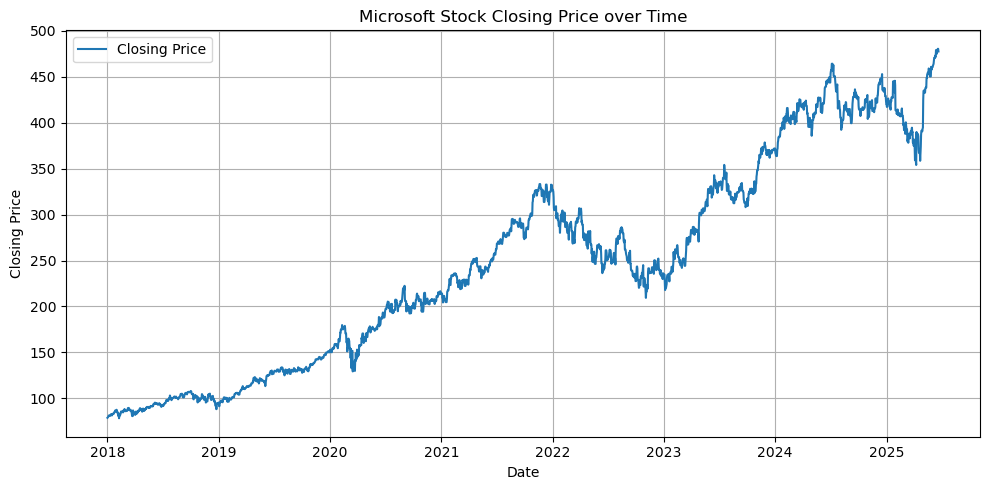

In [26]:
plt.figure(figsize = (10,5))
plt.plot(msft_df.index, msft_df["close"], label = "Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Microsoft Stock Closing Price over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Stationarity Check**

**Rolling Statistics**

Rolling statistics compute summary statistics (like mean or standard deviation) over a moving window of fixed size across the time series data.

For example, if you have a time series y_t, a rolling mean with a window of size 7 computes the average of y_t from day 1 to day 7, then from day 2 to day 8, and so on.

**How does it help check Stationarity?**

A stationary time series has:

<ul>
    <li>Constant mean over time</li>
    <li>Constant variance over time</li>
    <li>No periodic patterns (seasonality or trend)</li>
</ul>

**Rolling statistics help you check this visually:**

If the rolling mean and rolling standard deviation remain relatively flat (constant) over time, the series is likely stationary. If they drift (e.g., rising mean or increasing spread), the series is non-stationary.

(a) Short-Term Moving Average and Volatility

In [31]:
# Moving average of 7 days
moving_avg_7 = msft_df["close"].rolling(window = 7).mean().dropna()

# Moving volatility of 7 days
moving_std_7 = msft_df["close"].rolling(window = 7).std().dropna()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Average')

Text(0.5, 1.0, 'Short-Term Moving Average over time (7 Days)')

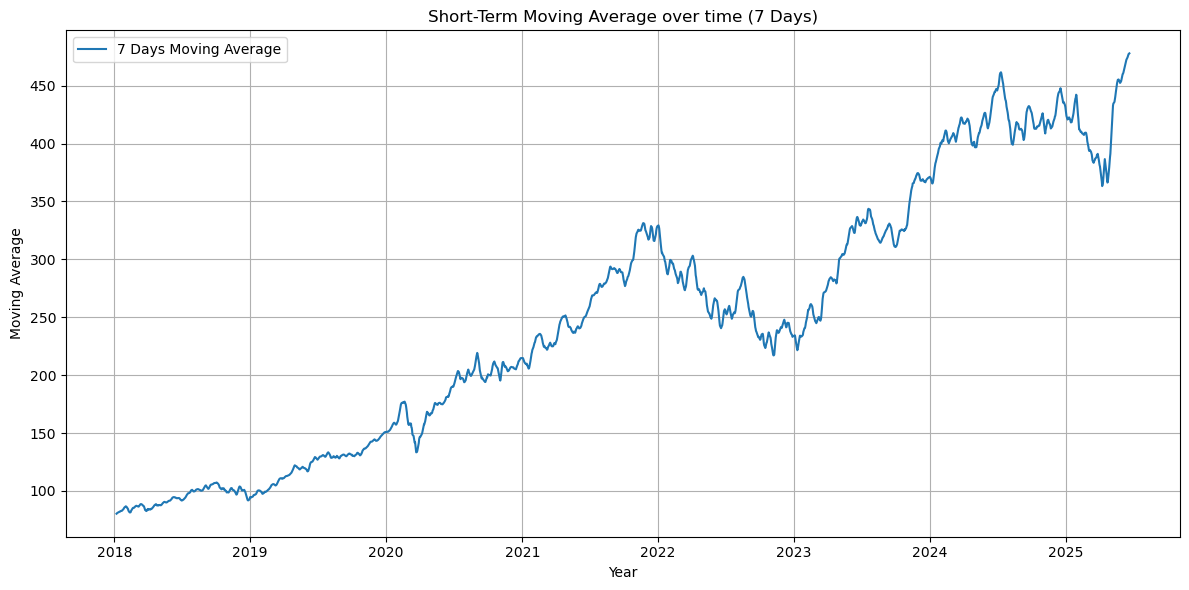

In [32]:
plt.figure(figsize = (12,6))
plt.plot(moving_avg_7, label = "7 Days Moving Average")
plt.xlabel("Year")
plt.ylabel("Moving Average")
plt.title("Short-Term Moving Average over time (7 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The 7-day moving average is a smoothing technique that calculates the average closing price over the previous 7 days, updating it for each day. It helps reduce short-term noise and reveals short-term trends.

**Overall Trend:**
<ul>
    <li>The graph shows a strong upward trend from 2018 to 2022</li>
    <li>It becomes more volatile with peaks and dips—especially visible in 2022–2023</li>
    <li>The stock appears to recover strongly in 2024–2025</li>
</ul>

This tells us that Microsoft’s stock experienced:

<ul>
    <li>Long-term growth from 2018 to 2022</li>
    <li>Corrections or turbulence in 2022-23</li>
    <li>A resumption of upward momentum in 2024</li>
</ul>

**Short-Term Fluctuations:**

Even though it’s a smoothed line, you can still see:

<ul>
    <li>Local peaks and valleys, which show temporary up/down trends</li>
    <li>These fluctuations may correspond to earnings reports, market events, or macroeconomic changes</li>
</ul>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Volatility')

Text(0.5, 1.0, 'Short-Term Moving Volatility over time (7 Days)')

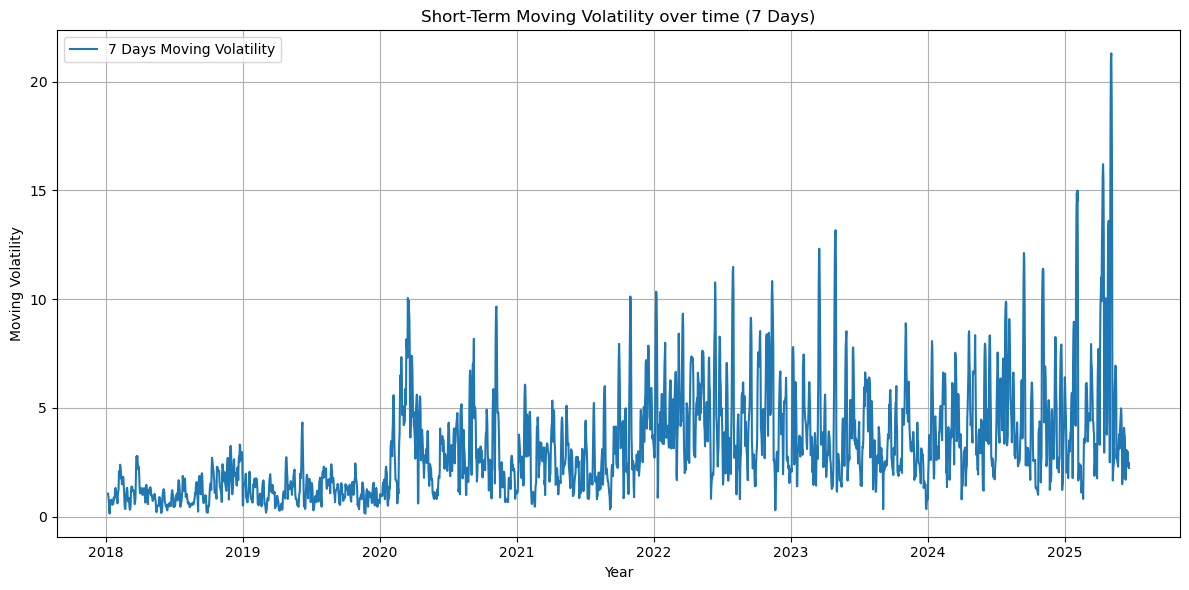

In [34]:
plt.figure(figsize = (12,6))
plt.plot(moving_std_7, label = "7 Days Moving Volatility")
plt.xlabel("Year")
plt.ylabel("Moving Volatility")
plt.title("Short-Term Moving Volatility over time (7 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ul>
    <li>Each point on the line represents the standard deviation of the past 7 days of closing prices</li>
    <li>Higher spikes = more price variability (higher volatility)</li>
    <li>Lower regions = stable price movement (lower volatility)</li>
</ul>

**Overall Trend in Volatility**
<ul>
    <li>From 2018 to 2019, volatility was low and stable</li>
    <li>Starting around 2020, there's a noticeable increase in spikes, especially:</li>
</ul>
<ol>
    <li>Early 2020 (COVID-19 market shock)</li>
    <li>Mid-2022 to 2023 (global inflation, tech sector fluctuations)</li>
    <li>Late 2024 into 2025 — showing the highest volatility</li>
</ol>

**Interpretation**: The Microsoft stock became increasingly volatile over the years, suggesting market uncertainty or larger daily price swings.

(b) Medium-Term Moving Average and Volatility

In [37]:
# Moving average of 21 days
moving_avg_21 = msft_df["close"].rolling(window = 21).mean().dropna()

# Moving volatility of 21 days
moving_std_21 = msft_df["close"].rolling(window = 21).std().dropna()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Average')

Text(0.5, 1.0, 'Medium-Term Moving Average over time (21 Days)')

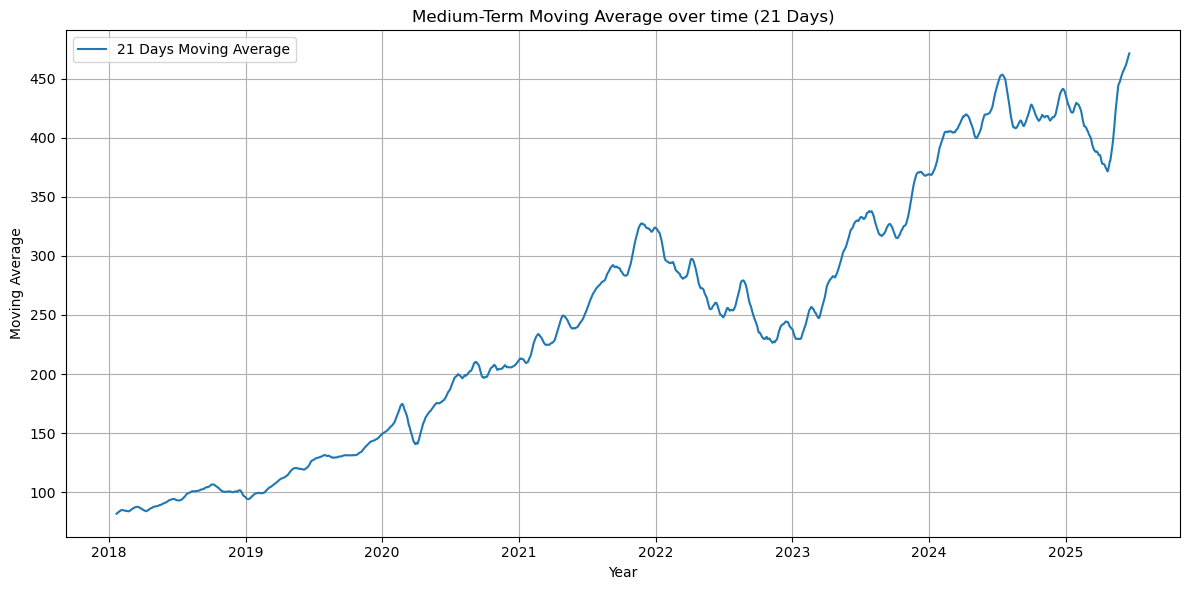

In [38]:
plt.figure(figsize = (12,6))
plt.plot(moving_avg_21, label = "21 Days Moving Average")
plt.xlabel("Year")
plt.ylabel("Moving Average")
plt.title("Medium-Term Moving Average over time (21 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A 21-day moving average smooths out the closing price over about 1 month of trading days. It helps detect monthly price trends while filtering out short-term noise.

<ul>
    <li>2018-21: Steady upward trajectory, indicating sustained growth in Microsoft's stock.</li>
    <li>2022-23: Noticeable volatility and pullbacks. The curve flattens or dips periodically, indicating market corrections or uncertain sentiment. Likely influenced by broader tech sell-offs and macroeconomic events.</li>
    <li>2024-25: Strong recovery and renewed upward movement. New all-time highs by mid-2025 suggest strong investor sentiment or strong financial performance.</li>
</ul>

**Interpretation**:

The 21-day MA is excellent for identifying medium-term trend reversals. Dips in the curve could indicate buying opportunities, while peaks may signal overbought conditions.

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Volatility')

Text(0.5, 1.0, 'Medium-Term Moving Volatility over time (21 Days)')

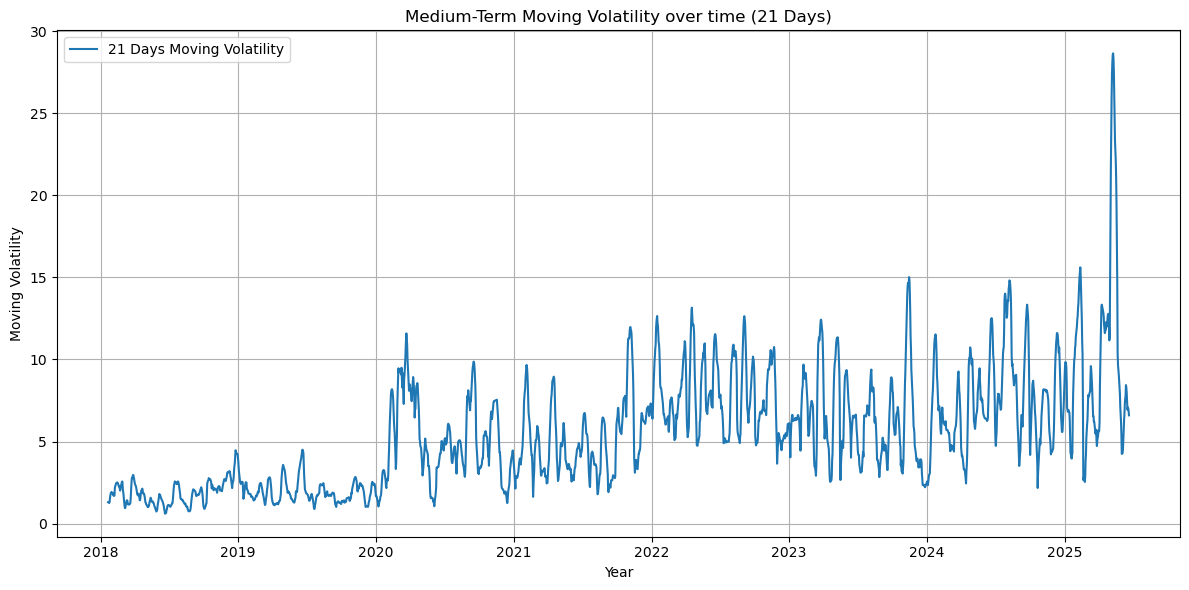

In [40]:
plt.figure(figsize = (12,6))
plt.plot(moving_std_21, label = "21 Days Moving Volatility")
plt.xlabel("Year")
plt.ylabel("Moving Volatility")
plt.title("Medium-Term Moving Volatility over time (21 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ul>
    <li>2018-19: Very low volatility (~1 to 3), indicating a stable growth phase.</li>
    <li>2020 (Pandemic Onset): Sharp volatility spike, exceeding 10 — consistent with the global market panic during COVID-19.</li>
    <li>2021-22: Frequent and sharp volatility spikes, showing uncertainty in tech markets, earnings surprises, or macroeconomic pressures.</li>
    <li>Late 2024-25: Highest volatility peaks observed (approaching 30), indicating - major market reactions, possible speculative trading, or event-driven price shocks (e.g., M&A, regulation, AI-related volatility).</li>
</ul>

In [42]:
# Moving average of 63 days
moving_avg_63 = msft_df["close"].rolling(window = 63).mean().dropna()

# Moving volatility of 63 days
moving_std_63 = msft_df["close"].rolling(window = 63).std().dropna()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Average')

Text(0.5, 1.0, 'Medium-Term Moving Average over time (63 Days)')

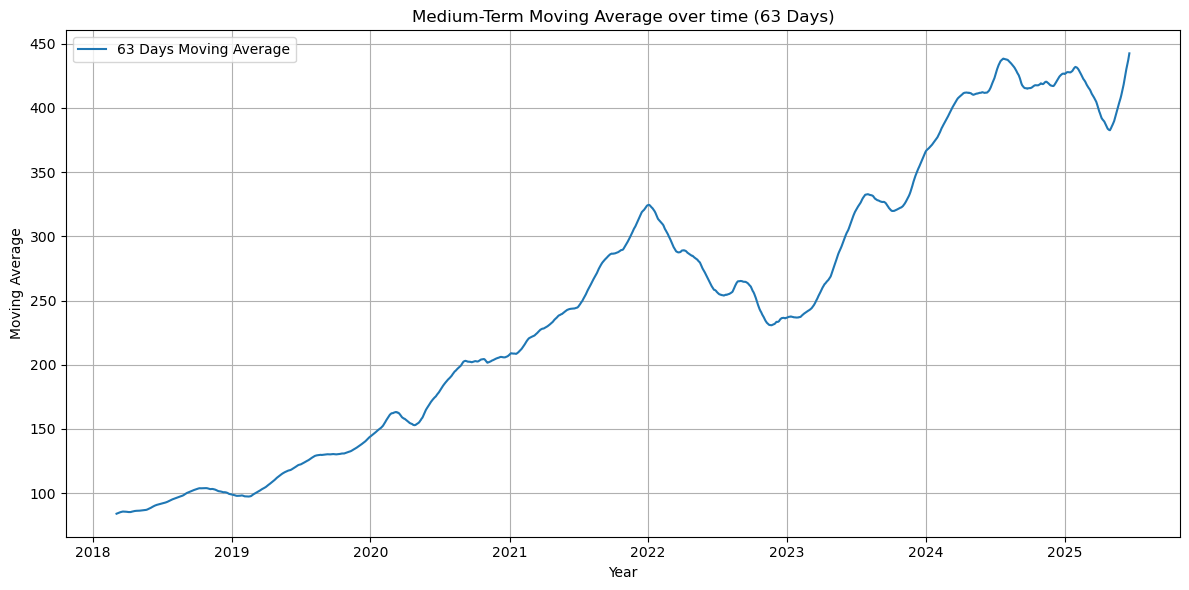

In [43]:
plt.figure(figsize = (12,6))
plt.plot(moving_avg_63, label = "63 Days Moving Average")
plt.xlabel("Year")
plt.ylabel("Moving Average")
plt.title("Medium-Term Moving Average over time (63 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ul>
    <li>Trend: The 63-day moving average shows a strong overall upward trend from 2018 into mid-2022, indicating sustained growth over medium-term periods.</li>
    <li>Volatility: There's a noticeable dip and flattening in late 2022 to early 2023, similar to the 21-day moving average, suggesting a period of correction or uncertainty.</li>
    <li>Recovery: From mid-2023 onwards, the 63-day moving average shows a strong recovery and renewed upward momentum, reaching new highs in 2024 and early 2025 before a slight downturn at the very end of the visible data.</li>
    <li>Interpretation: This moving average is excellent for identifying medium-to-long term trend reversals and sustained directional movements over quarterly periods.</li>
</ul>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Volatility')

Text(0.5, 1.0, 'Medium-Term Moving Volatility over time (63 Days)')

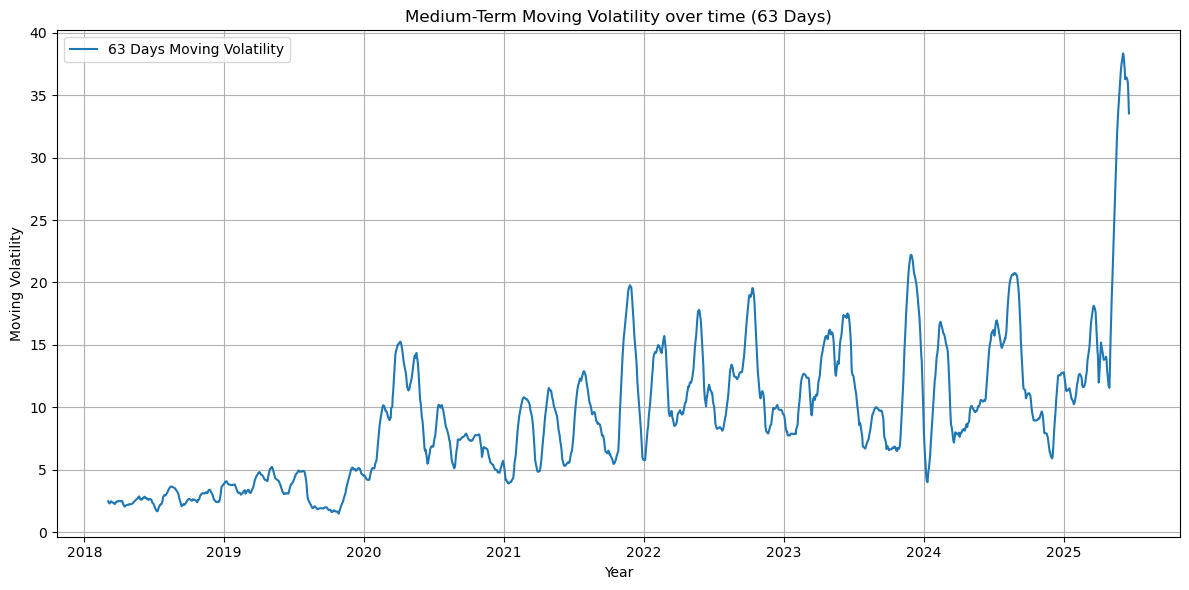

In [45]:
plt.figure(figsize = (12,6))
plt.plot(moving_std_63, label = "63 Days Moving Volatility")
plt.xlabel("Year")
plt.ylabel("Moving Volatility")
plt.title("Medium-Term Moving Volatility over time (63 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ul>
    <li>Early Period (2018-2019): Volatility was relatively low and stable, generally staying below 5. This suggests a period of more predictable and less volatile price movements for Microsoft stock.</li>
    <li>Increase (2020 onwards): Similar to the shorter-term volatilities, there's a significant increase in spikes starting around 2020. This indicates higher price variability and increased market uncertainty.</li>
    <li>Higher Spikes: Noticeable peaks occur in early 2020 (likely related to the COVID-19 market shock), throughout 2022-2023 (consistent with global inflation and tech sector fluctuations), and particularly in late 2024 into 2025, where the volatility reaches its highest points (approaching 35-40).</li>
    <li>Interpretation: The increasing magnitude and frequency of spikes in the 63-day moving volatility suggest that Microsoft stock has become increasingly volatile over quarterly periods in recent years, implying larger price swings and greater market uncertainty or event-driven reactions.</li>
</ul>

(c) Long-Term Moving Average and Volatility

In [48]:
# Moving average of 252 days
moving_avg_252 = msft_df["close"].rolling(window = 252).mean().dropna()

# Moving volatility of 252 days
moving_std_252 = msft_df["close"].rolling(window = 252).std().dropna()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Average')

Text(0.5, 1.0, 'Long-Term Moving Average over time (252 Days)')

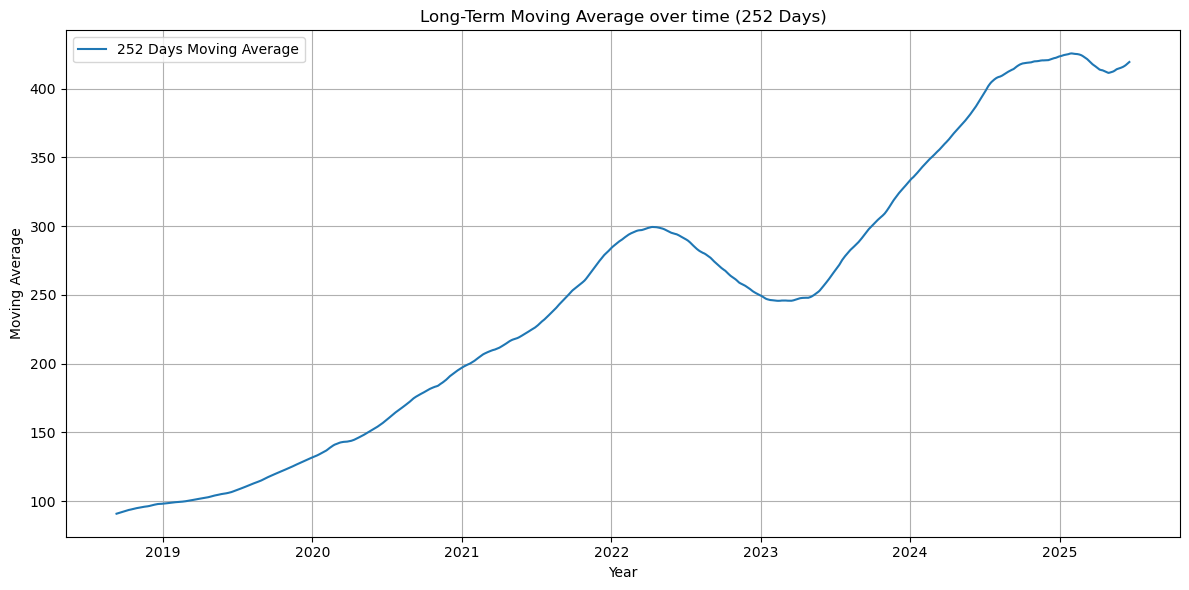

In [49]:
plt.figure(figsize = (12,6))
plt.plot(moving_avg_252, label = "252 Days Moving Average")
plt.xlabel("Year")
plt.ylabel("Moving Average")
plt.title("Long-Term Moving Average over time (252 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ul>
    <li>Long-Term Growth: The plot shows a strong and consistent upward trajectory from 2019 through mid-2022, reflecting significant long-term growth in Microsoft's stock price.</li>
    <li>Flattening/Dip: There is a noticeable flattening and slight dip in the curve from mid-2022 to early 2023, indicating a period where the long-term growth slowed or slightly reversed. This suggests a more prolonged period of market correction or uncertainty compared to shorter-term analyses.</li>
    <li>Renewed Upward Trend: From mid-2023 onwards, the 252-day moving average demonstrates a robust recovery and a clear resumption of the upward trend, reaching new long-term highs in 2024 and 2025.</li>
    <li>Interpretation: This long-term moving average is crucial for understanding the overall, underlying trend of Microsoft's stock, effectively filtering out short-term and medium-term noise to reveal the sustained direction of the stock's price. It highlights periods of consistent long-term growth and sustained market sentiment changes.</li>
</ul>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Moving Volatility')

Text(0.5, 1.0, 'Long-Term Moving Volatility over time (252 Days)')

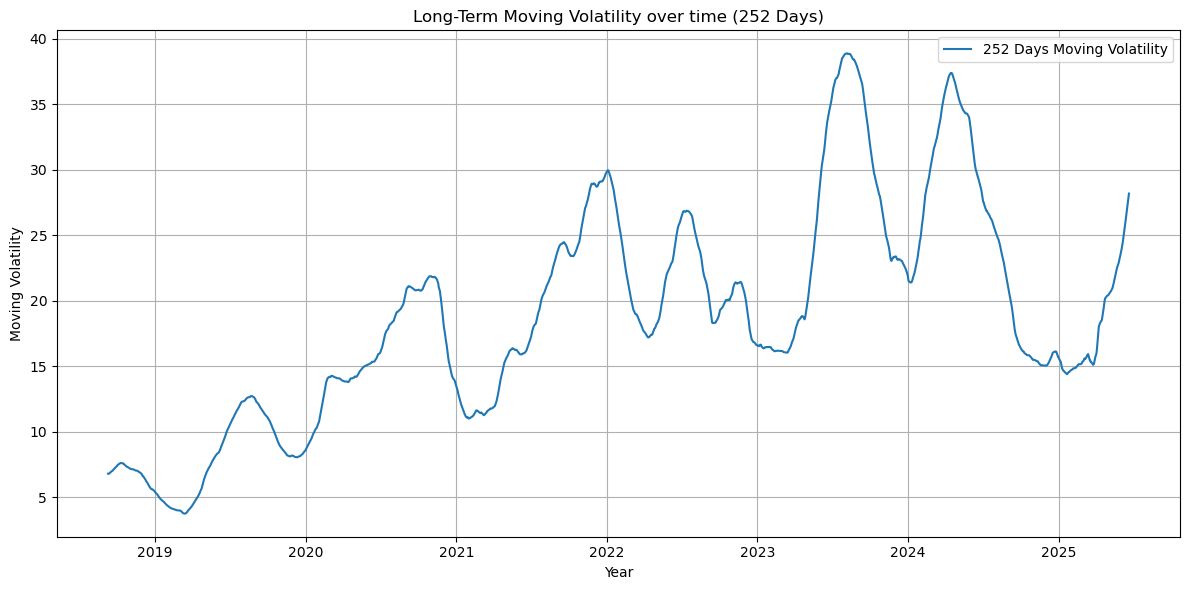

In [51]:
plt.figure(figsize = (12,6))
plt.plot(moving_std_252, label = "252 Days Moving Volatility")
plt.xlabel("Year")
plt.ylabel("Moving Volatility")
plt.title("Long-Term Moving Volatility over time (252 Days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ul>
    <li>Early Stability (2018-2019): Volatility was relatively low and stable, generally below 10, indicating a period of long-term price stability.</li>
    <li>Increasing Volatility: From late 2019/early 2020 onwards, the 252-day moving volatility shows a general upward trend with several significant peaks. This indicates that the long-term price fluctuations have become more pronounced.</li>
    <li>Major Peaks: Notable peaks are observed around late 2020, throughout 2022, and especially in 2024, where the volatility reaches its highest points (approaching 40). These peaks suggest prolonged periods of increased uncertainty, significant market events, or sustained changes in investor behavior that led to larger price swings over a yearly horizon.</li>
    <li>Interpretation: The 252-day moving volatility provides insight into the long-term stability or instability of Microsoft's stock. The overall increasing trend and higher peaks suggest that while the stock has experienced significant long-term growth, this growth has come with increased inherent risk and larger price variations over annual periods.</li>
</ul>

**Augmented Dickey-Fuller (ADF) Test** 

<ul>
    <li>Purpose: Formally tests for unit root (non-stationarity)</li>
    <li>Null Hypothesis (H₀): Series is non-stationary</li>
    <li>Alternative Hypothesis (H₁): Series is stationary</li>
    <li>Output: Test statistic and p-value</li>
    <li>If p-value < 0.05 and test statistics is more negative, reject H₀ ⇒ data is stationary</li>
</ul>

In [55]:
adf = adfuller(msft_df['close'])

# Test Statistics
print("Test Statistics: {}".format(adf[0]))
print(" ")

# p-Value
print("p-value: {}".format(adf[1]))
print(" ")

# Critical Value (5%)
print("Critical Value (5%): {}".format(adf[4]['5%']))

Test Statistics: -0.09098316562053906
 
p-value: 0.9503292719776542
 
Critical Value (5%): -2.8626063225123146


**Observation**:

1. Test Statistic > Critical Value (i.e., -0.09 > -2.86): Fail to reject the null hypothesis.

2. p-value = 0.95 (≫ 0.05): Again, this supports failing to reject the null hypothesis.

From the rolling statistics and ADF test, we checked that the data is non-stationary.

#### **Decompose the Time Series**

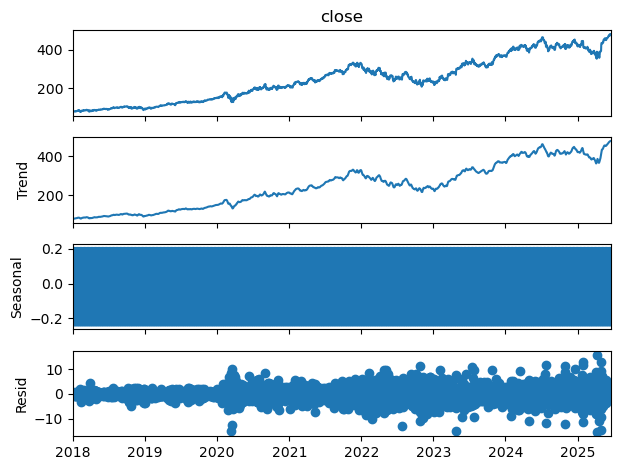

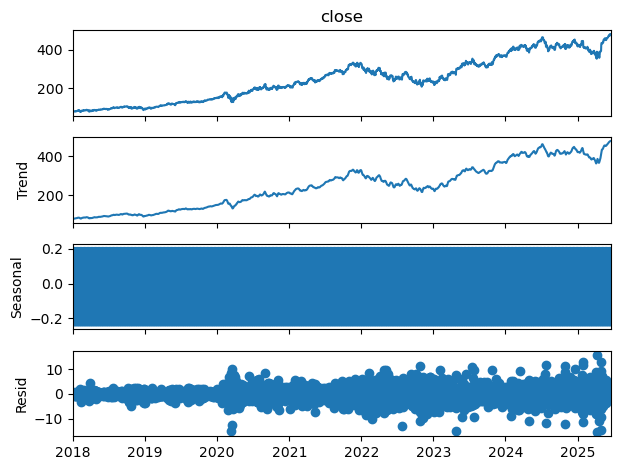

In [59]:
decomposition_7 = seasonal_decompose(msft_df['close'], model = 'additive', period = 7)

decomposition_7.plot()

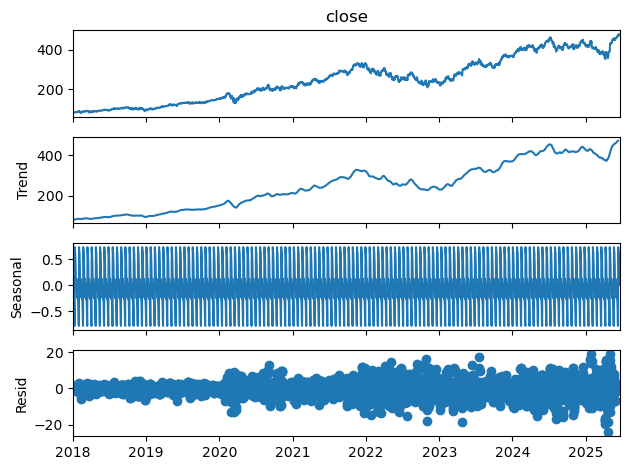

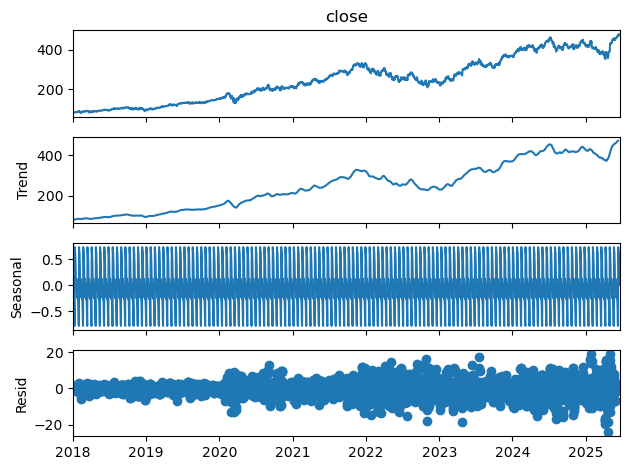

In [60]:
decomposition_21 = seasonal_decompose(msft_df['close'], model = 'additive', period = 21)

decomposition_21.plot()

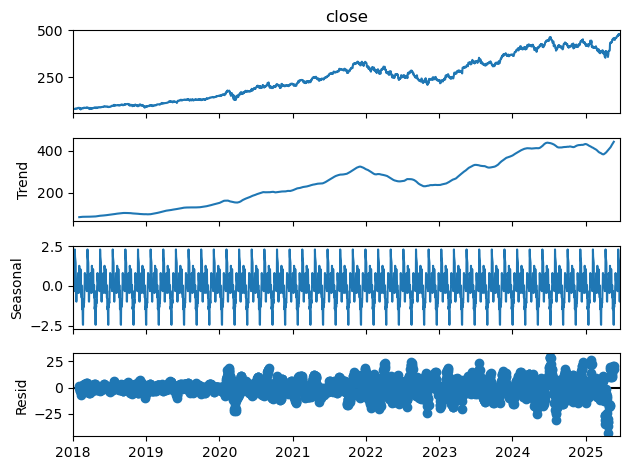

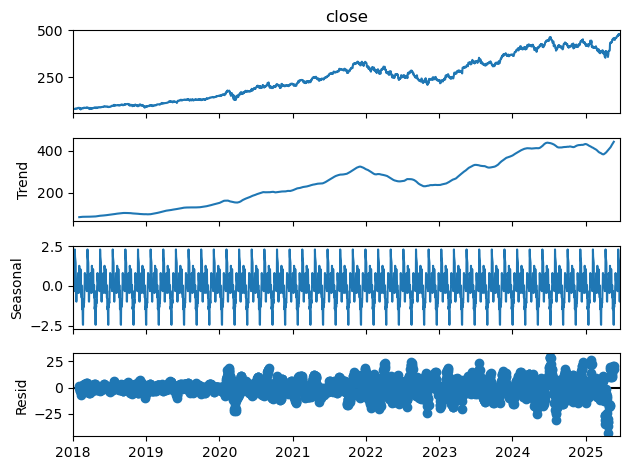

In [61]:
decomposition_63 = seasonal_decompose(msft_df['close'], model = 'additive', period = 63)

decomposition_63.plot()

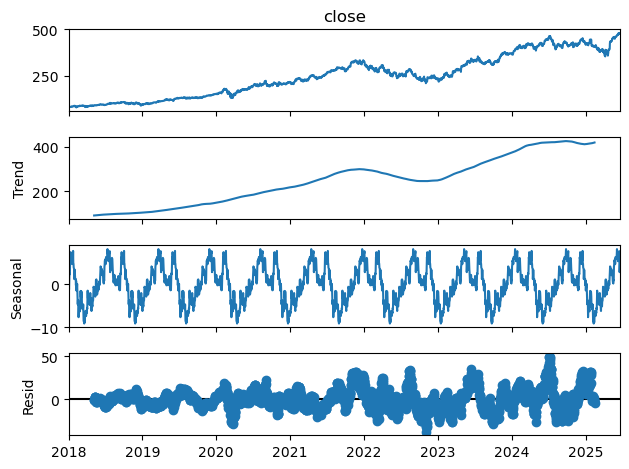

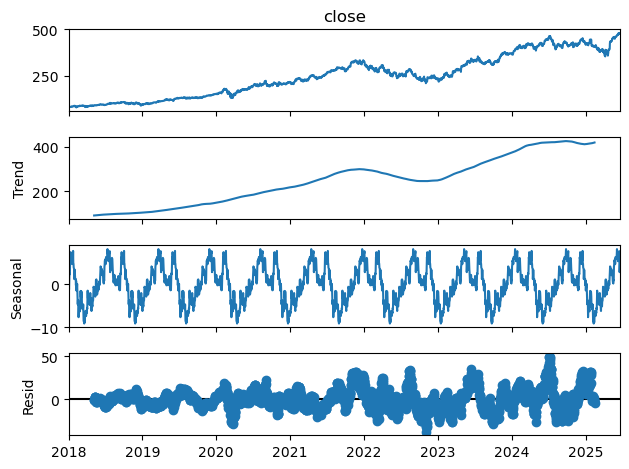

In [62]:
decomposition_252 = seasonal_decompose(msft_df['close'], model = 'additive', period = 252)

decomposition_252.plot()

1. Original Series (Close)

The original Microsoft stock closing price shows a consistent upward trend with fluctuations across all decompositions, aligning with observed moving averages.

2. Trend Component
<ul>
    <li>7-Day: Captures short-term directional shifts.</li>
    <li>21-Day: Highlights monthly trends, showing growth (2018–2021), volatility (2022–2023), and strong recovery (2024–2025).</li>
    <li>63-Day: Smooths out noise to show quarterly trends—strong growth until mid-2022, a dip, and recovery starting mid-2023.</li>
    <li>252-Day: Represents long-term growth, clearly showing sustained gains, a flattening in 2022–2023, and a robust rise thereafter.</li>
    <li>Overall: Trend becomes smoother with larger windows, revealing the underlying long-term movement.</li>
</ul>

3. Seasonal Component
<ul>
    <li>7-Day: Flat, indicating no weekly seasonality.</li>
    <li>21-Day: Minor monthly cyclicality with low amplitude.</li>
    <li>63-Day: Clear quarterly seasonality with moderate amplitude.</li>
    <li>252-Day: Strong annual patterns with high amplitude, indicating consistent yearly cycles.</li>
    <li>Overall: Seasonality grows more prominent with longer decomposition windows.</li>
</ul>

4. Residual Component
<ul>
    <li>Outliers: Spikes highlight events not captured by trend or seasonality (e.g., market shocks).</li>
    <li>Variance: Residuals increase in magnitude over time, especially post-2024, indicating rising unpredictability.</li>
    <li>Overall: Residual patterns are similar across decompositions but grow in volatility over time.</li>
</ul>

#### **Time Series Transformation**

Stationarity Method: **Differencing**

In [66]:
# First Difference
msft_df["first_diff"] = msft_df["close"].diff().dropna()
msft_df.dropna(inplace = True)

# Glimpse of the data
msft_df.head(10)

,close,first_diff
2018-01-02,79.33,0.38
2018-01-03,79.70,0.37
2018-01-04,80.40,0.70
2018-01-05,81.40,1.00
2018-01-06,81.40,0.00
2018-01-07,81.40,0.00
2018-01-08,81.48,0.08
2018-01-09,81.42,-0.06
2018-01-10,81.05,-0.37
2018-01-11,81.29,0.24


In [67]:
# Rerun the adf test
adf_d1 = adfuller(msft_df["first_diff"])

# Test Statistics (First Order Differencing)
print("Test Statistics (First Order Differencing): {}".format(adf_d1[0]))
print(" ")

# p-Value (First Order Differencing)
print("p-value (First Order Differencing): {}".format(adf_d1[1]))
print(" ")

# Critical Value (5%) (First Order Differencing)
print("Critical Value (5%) (First Order Differencing): {}".format(adf_d1[4]['5%']))

Test Statistics (First Order Differencing): -13.97432176699672
 
p-value (First Order Differencing): 4.2889884129443746e-26
 
Critical Value (5%) (First Order Differencing): -2.8626063225123146


In [68]:
if (adf_d1[0] < adf_d1[4]['5%']) and (adf_d1[1] < 0.05):
    print("Rejected the Null Hypothesis. Hence, the data is stationary.")
else:
    print("Fail to reject the Null Hypothesis. Hence, the data is non-stationary.")

Rejected the Null Hypothesis. Hence, the data is stationary.


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Closing Price')

Text(0.5, 1.0, 'Stationary Vs Non-Stationary of Microsoft Stock over Time')

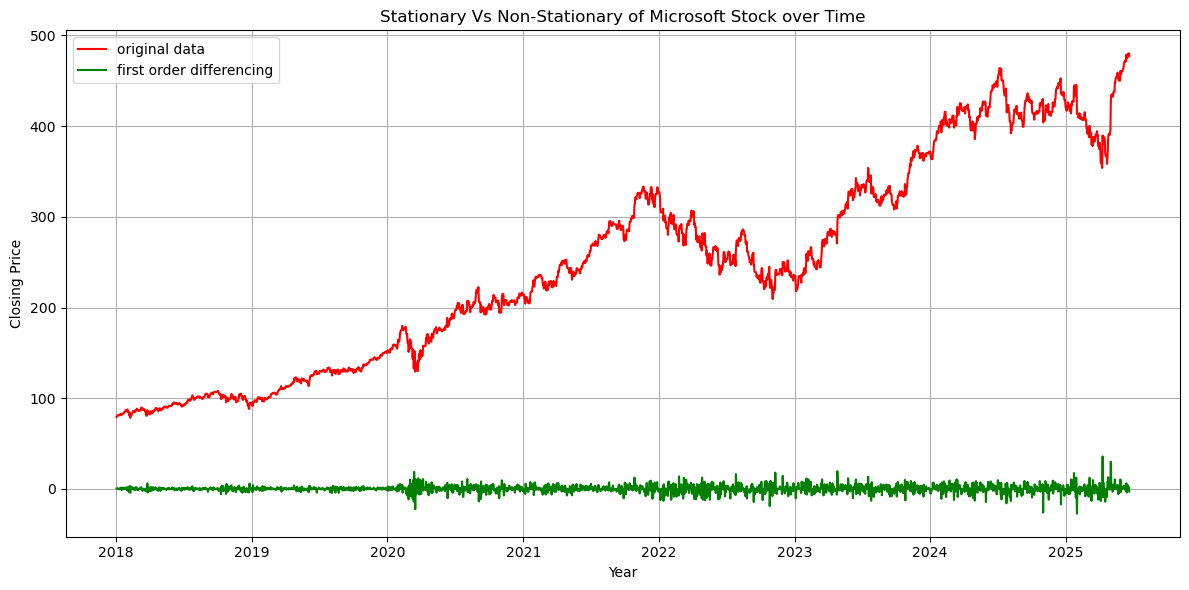

In [69]:
# Plot the Time Series
plt.figure(figsize = (12,6))
plt.plot(msft_df["close"], color = "red", label = "original data")
plt.plot(msft_df["first_diff"], color = "green", label = "first order differencing")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.title("Stationary Vs Non-Stationary of Microsoft Stock over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Correlation & Lags**

Autocorrelation & Partial Autocorrelation

**ACF and PACF plot should be plotted on non-stationary or stationary data?**

In time series analysis, ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots should ideally be plotted on stationary data.

1. Purpose of ACF and PACF:

They help in identifying the order of AR (AutoRegressive) and MA (Moving Average) components in an ARIMA or SARIMA model. These models assume that the input time series is stationary.

2. Non-stationary data leads to misleading ACF/PACF:

If you plot ACF/PACF on non-stationary data (e.g., trending or seasonal), the plots often show slowly decaying autocorrelations, which are hard to interpret. You'll likely see high autocorrelations across many lags, making it difficult to determine the actual order.

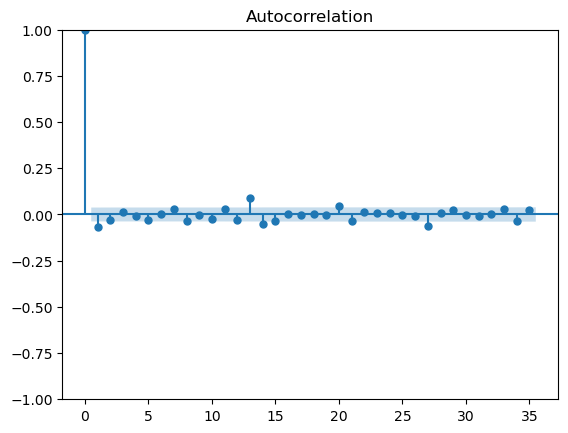

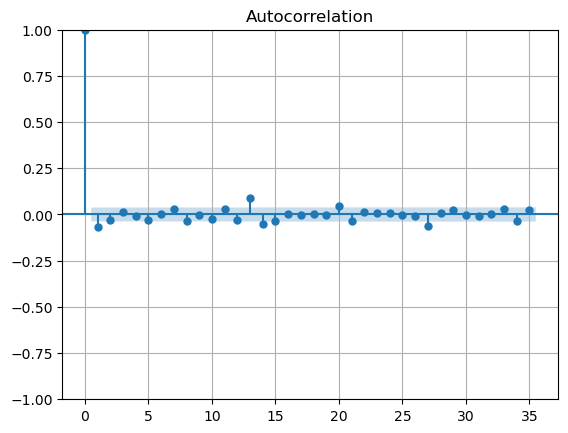

In [73]:
# Autocorrelation
plot_acf(msft_df['first_diff'].dropna())
plt.grid()

The ACF measures the correlation between a time series and a lagged version of itself. For example, the ACF at lag 1 measures the correlation between Yt and Yt−1, at lag 2 it measures the correlation between Yt and Yt−2, and so on. In the plot, the blue spikes represent the autocorrelation values at different lags, and the shaded blue region represents the confidence interval. If a spike extends beyond this confidence interval, it indicates a statistically significant correlation.

<ul>
    <li>Lag 0: The ACF at lag 0 is always 1, as a series is perfectly correlated with itself.</li>
    <li>Significant Lag at 1: The most prominent spike is at lag 1, indicating a strong positive correlation between the current closing price and the closing price of the previous day. This is typical for stock prices, as today's price is heavily influenced by yesterday's price.</li>
    <li>Rapid Decay: After lag 1, the ACF values quickly drop and remain mostly within the blue shaded region (confidence interval), with only a few minor spikes slightly outside, particularly around lag 13.</li>
</ul>

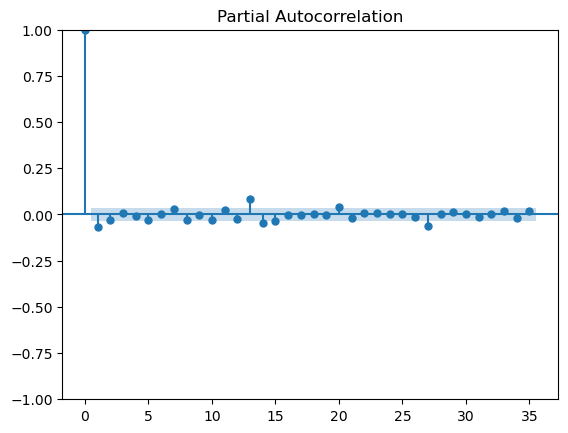

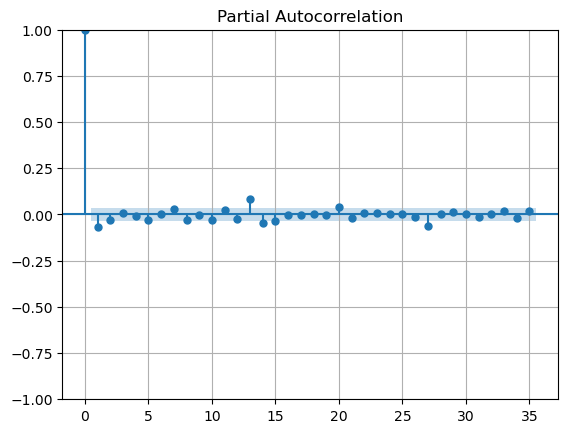

In [75]:
# Partial Autocorrelation
plot_pacf(msft_df['first_diff'].dropna())
plt.grid()

The PACF measures the correlation between a time series and a lagged version of itself, after controlling for the effects of all intermediate lags. For example, the PACF at lag 3 measures the correlation between Yt and Yt−3, but only the direct correlation that is not explained by the influence of Yt−1 and Yt−2. Like the ACF, spikes outside the shaded region are statistically significant.

<ul>
    <li>Lag 0: Similar to ACF, PACF at lag 0 is 1.</li>
    <li>Significant Lag at 1: The PACF also shows a strong positive spike at lag 1, indicating a direct significant relationship between the current observation and the immediately preceding one.</li>
    <li>Immediate Drop: After lag 1, the PACF values immediately drop to near zero and stay mostly within the confidence interval, similar to the ACF. The minor spike around lag 13 is also present but remains within the bounds for most parts.</li>
</ul>

### Model Development

<ol>
    <li>ARIMA</li>
    <li>SARIMA</li>
    <li>ARIMA-GARCH</li>
    <li>XGBoost</li>
    <li>LSTM</li>
</ol>

#### **ARIMA**

In [80]:
# Dataset for ARIMA Model
arima_df = msft_df[["close"]]

# Glimse of the Data
arima_df.head()

,close
2018-01-02,79.33
2018-01-03,79.70
2018-01-04,80.40
2018-01-05,81.40
2018-01-06,81.40


<font color = "blue">(a) Time-based Train-Validation-Test Split</font>

<ul>
    <li>Training Set (5 Years): 2018 - 2022</li>
    <li>Validation Set (1 Year): 2023</li>
    <li>Test Set (~1.5 Years): 2024 - mid 2025</li>
</ul>

In [83]:
df_train = arima_df.loc["2018-01-02" : "2022-12-31"]
df_val = arima_df.loc["2023-01-01" : "2023-12-31"]
df_test = arima_df.loc["2024-01-01" : "2025-06-20"]

print("The training data contains {} days.".format(len(df_train)))
print(" ")
print("The validation data contains {} days.".format(len(df_val)))
print(" ")
print("The test data contains {} days.".format(len(df_test)))

The training data contains 1825 days.
 
The validation data contains 365 days.
 
The test data contains 537 days.


<font color = "blue">(b) Visualize the Split</font>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Closing Price')

Text(0.5, 1.0, 'Train Vs Validation Vs Test Data')

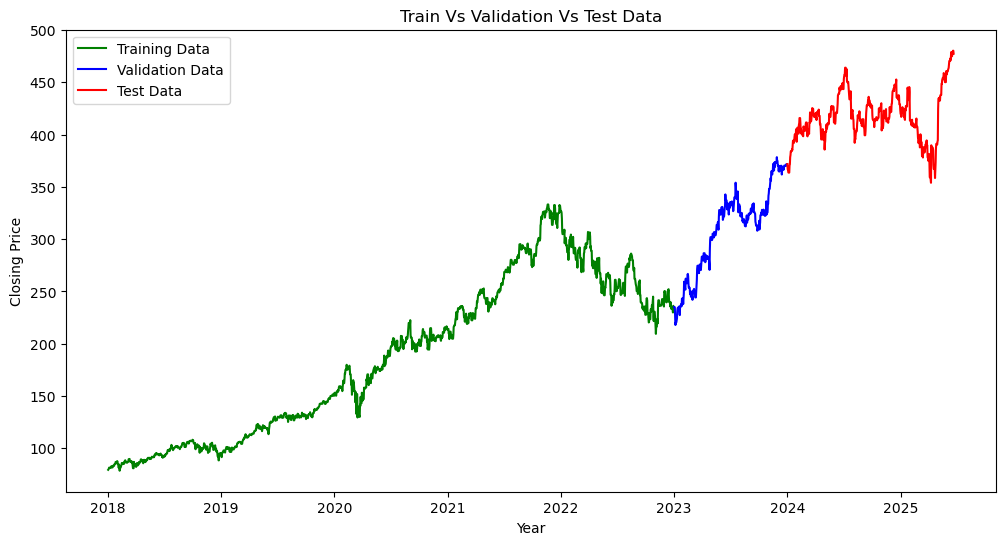

In [85]:
plt.figure(figsize = (12,6))
plt.plot(df_train['close'], label = "Training Data", color = "Green")
plt.plot(df_val['close'], label = "Validation Data", color = "Blue")
plt.plot(df_test['close'], label = "Test Data", color = "Red")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.title("Train Vs Validation Vs Test Data")
plt.legend()
plt.show()

<font color = "blue">(c) Fit the ARIMA model on Training Data</font>

From the above ACF / PACF plot and stationarity checks, we got p = 1 (PACF), q = 1 (ACF), and d = 1 (First Order Differencing). 

In [88]:
# Initialize the ARIMA Model on Training Data
arima_model = ARIMA(df_train['close'], order = (1, 1, 1))

# Fit the ARIMA Model
arima_model_fit = arima_model.fit()

# Summary of the ARIMA Model
print("Summary of the ARIMA Model")
print(" ")
print(arima_model_fit.summary())

Summary of the ARIMA Model
 
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1825
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4665.125
Date:                Thu, 26 Jun 2025   AIC                           9336.251
Time:                        12:04:43   BIC                           9352.777
Sample:                    01-02-2018   HQIC                          9342.347
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1818      0.150      1.210      0.226      -0.113       0.476
ma.L1         -0.2929      0.148     -1.974      0.048      -0.584      -0.002
sigma2         9.7511  

##### **Explanation of Summary Table**

1. Model Information
<ul>
    <li>Dep. Variable: close - This indicates that the model is predicting the 'close' price of the stock.</li>
    <li>Model: ARIMA(1, 1, 1) - Confirms the order of the fitted ARIMA model.</li>
    <li>No. Observations: 1825 - The number of data points used in the training set.</li>
    <li>Log Likelihood: -4665.125 - A measure of how well the model fits the data. Higher values indicate a better fit.</li>
    <li>AIC (Akaike Information Criterion): 9336.251 - A measure of model fit that penalizes for complexity. Lower AIC values are preferred.</li>
    <li>BIC (Bayesian Information Criterion): 9352.777 - Similar to AIC but with a stronger penalty for more parameters. Lower BIC values are preferred.</li>
    <li>HQIC (Hannan-Quinn Information Criterion): 9342.347 - Another criterion for model selection, similar to AIC and BIC</li>
</ul>
<br>
2. Coefficients

**ar.L1 (Autoregressive Lag 1)**
<ul>
    <li>coef: 0.1818 - The estimated coefficient for the AR(1) term.</li>
    <li>P>|z|: 0.226 - The p-value for this coefficient. Since 0.226 is greater than a common significance level (e.g., 0.05), this ar.L1 term is not statistically significant. This suggests that the direct autoregressive relationship with the previous day's value, after differencing and accounting for the MA term, might not be strong enough to be considered statistically different from zero.</li>
</ul>

**ma.L1 (Moving Average Lag 1)**
<ul>
    <li>coef: -0.2929 - The estimated coefficient for the MA(1) term.</li>
    <li>P>|z|: 0.048 - The p-value for this coefficient. Since 0.048 is less than 0.05, this ma.L1 term is statistically significant. This indicates that the error from the previous day's prediction has a significant impact on the current prediction.</li>
</ul>

**sigma2**
<ul>
    <li>sigma2: 9.7511 - This represents the estimated variance of the innovations (residuals). Its p-value is 0.000, indicating it's highly significant, meaning there's significant variability in the errors.</li>
</ul>
<br>

3. Diagnostics (Ljung-Box, Jarque-Bera, Heteroskedasticity)

These tests assess the quality of the model's residuals (the errors or "leftovers" after the model has captured the trend and seasonality). For a good ARIMA model, the residuals should be white noise (i.e., uncorrelated, normally distributed, and with constant variance).

**Ljung-Box (LBO)**

Prob(Q): 0.99 (for L1) and 0.00 - The p-value for the overall test for multiple lags, which at 0.00 would indicate remaining autocorrelation in the residuals, suggesting the model might not have captured all the underlying patterns.

**Jarque-Bera (JB)**

Prob(JB): 0.00 - This tests for the normality of the residuals. A p-value of 0.00 (less than 0.05) indicates that the residuals are not normally distributed.

**Heteroskedasticity (H)**

Prob(H) (two-sided): 0.00 - This tests if the variance of the residuals is constant over time (homoscedasticity). A p-value of 0.00 (less than 0.05) indicates the presence of heteroskedasticity, meaning the variance of the residuals is not constant and changes over time. This is consistent with the increasing volatility observed in the rolling volatility plots.

<font color = "blue">(d) Forecast Into Validation and Test Periods</font>

In [91]:
# Determine the Number of Steps to Forecast
val_steps = len(df_val)
test_steps = len(df_test)
total_steps = val_steps + test_steps

# Forecast Forward
arima_forecast = arima_model_fit.forecast(steps = total_steps)
arima_forecast.index = pd.date_range(start = df_val.index[0], periods = total_steps, freq = "D")

<font color = "blue">(e) Plot Forecast vs Actual</font>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Closing Price')

Text(0.5, 1.0, 'ARIMA (1,1,1) Model Actual Vs Forecast')

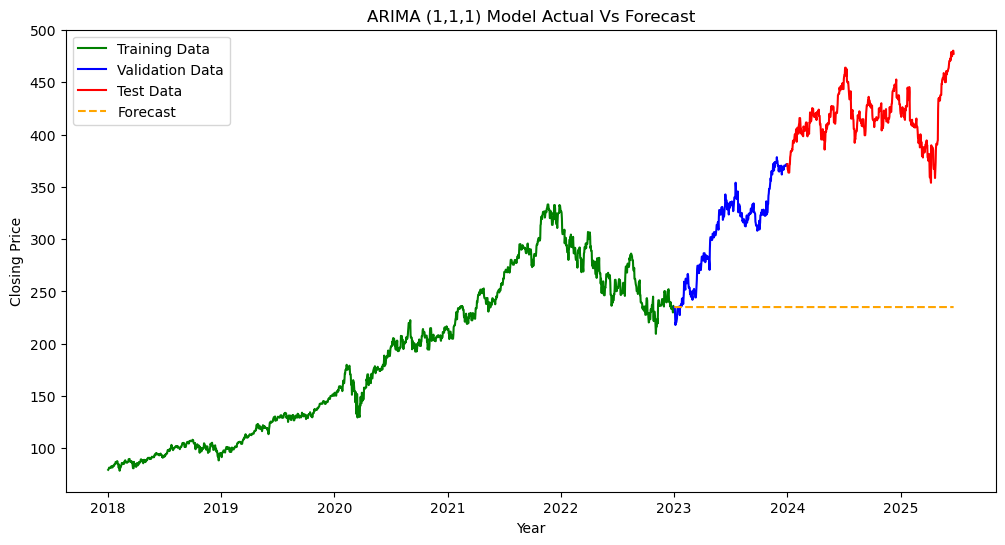

In [93]:
plt.figure(figsize = (12,6))
plt.plot(df_train['close'], label = "Training Data", color = "Green")
plt.plot(df_val['close'], label = "Validation Data", color = "Blue")
plt.plot(df_test['close'], label = "Test Data", color = "Red")
plt.plot(arima_forecast, label = "Forecast", linestyle = "--", color = "orange")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.title("ARIMA (1,1,1) Model Actual Vs Forecast")
plt.show()

<ul>
    <li>Microsoft stock has trends, cycles, and possibly non-linear dynamics.</li>
    <li>A basic ARIMA(1,1,1) may struggle to capture such long-term momentum.</li>
    <li>That’s why it's forecasting a flat future after differencing — the model assumes “no change” unless a strong signal is present in the residuals.</li>
</ul>

<font color = "blue">(f) Evaluate Performance</font>

In [96]:
# Evaluation on Training Set
train_forecast = arima_model_fit.predict(start = df_train.index[0], end = df_train.index[-1], typ='levels')

# 1. RMSE
train_rmse = np.sqrt(mean_squared_error(df_train['close'], train_forecast))
print(f"Training RMSE: {train_rmse:.2f}")

# 2. MSE
train_mse = mean_squared_error(df_train['close'], train_forecast)
print(f"Training MSE: {train_mse:.2f}")

# 3. MAPE
train_mape = mean_absolute_percentage_error(df_train['close'], train_forecast)
print(f"Training MAPE: {train_mape:.2f}%")

Training RMSE: 3.63
Training MSE: 13.19
Training MAPE: 1.02%


In [97]:
# Evaluation on Validation Set
val_forecast = arima_forecast[:val_steps]

# Metrics
# 1. RMSE
val_rmse = np.sqrt(mean_squared_error(df_val['close'], val_forecast))
print(f"Validation RMSE: {val_rmse:.2f}")

# 2. MSE
val_mse = mean_squared_error(df_val['close'], val_forecast)
print(f"Validation MSE: {val_mse:.2f}")

# 3. MAPE
val_mape = mean_absolute_percentage_error(df_val['close'], val_forecast)
print(f"Validation MAPE: {val_mape:.2f}%")

Validation RMSE: 85.01
Validation MSE: 7227.50
Validation MAPE: 22.80%


In [98]:
# Evaluation on Test Set
test_forecast = arima_forecast[val_steps:]

# Metrics
# 1. RMSE
test_rmse = np.sqrt(mean_squared_error(df_test['close'], test_forecast))
print(f"Test RMSE: {test_rmse:.2f}")

# 2. MSE
test_mse = mean_squared_error(df_test['close'], test_forecast)
print(f"Test MSE: {test_mse:.2f}")

# 3. MAPE
test_mape = mean_absolute_percentage_error(df_test['close'], test_forecast)
print(f"Test MAPE: {test_mape:.2f}%")

Test RMSE: 183.58
Test MSE: 33703.41
Test MAPE: 43.46%


**Training Set**

<ul>
    <li>Low error: MSE and RMSE are very small</li>
    <li>MAPE is just 1.02%, indicating very good fit on training data</li>
    <li>Model captures the training period well</li>
</ul>

**Validation Set**

<ul>
    <li>Drastic increase in error: RMSE jumps from 3.63 → 85.01</li>
    <li>MAPE is 22.80%, which is a major drop in accuracy</li>
    <li>Suggests model does not generalize well to unseen data</li>
</ul>

**Test Set**

<ul>
    <li>Errors become even worse: RMSE is 183.58, MAPE 43.46%</li>
    <li>The model's predictions deviate severely from actual prices</li>
    <li>Indicates it's not suitable for reliable future forecasting</li>
</ul>

**Next step would be try with different lags for p and q.**

----------------------------------------------------------------------------------------------------------------------------
**Experiment 2**
<ul>
    <li>p values = 8, 13, 20, 21</li>
    <li>q values = 8, 13, 20, 21</li>
    <li>d = 1</li>
</ul>

<font color = "blue">(a) Fit the ARIMA model on Training Data</font>

In [103]:
import warnings
warnings.simplefilter("ignore")

# Define lags
p_values = [8, 13, 20,21]
q_values = [8, 13, 20, 21]
d = 1

# Track the Best Model
best_aic = np.inf
best_order = None
best_model = None

# Fit the Model
for p in p_values:
    for q in q_values:
        try:
            arima_model_E2 = ARIMA(df_train["close"], order = (p, d, q))
            arima_model_E2_fit = arima_model_E2.fit()
            aic = arima_model_E2_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
                best_model = arima_model_E2_fit
        except Exception as e:
            print(f"ARIMA ({p},{d},{q}) - Failed to fit. Error: {e}")

<font color = "blue">(b) Best Model</font>

In [105]:
print(f"Best ARIMA Order: {best_order} with AIC: {best_aic:.2f}")

Best ARIMA Order: (8, 1, 21) with AIC: 9297.61


<font color = "blue">(c) Forecast Into Validation and Test Periods</font>

In [107]:
# Determine the Number of Steps to Forecast
val_steps = len(df_val)
test_steps = len(df_test)
total_steps = val_steps + test_steps

# Forecast Forward
arima_E2_forecast = best_model.forecast(steps = total_steps)
arima_E2_forecast.index = pd.date_range(start = df_val.index[0], periods = total_steps, freq = "D")

<font color = "blue">(d) Plot Forecast vs Actual</font>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Closing Price')

Text(0.5, 1.0, 'ARIMA ((8, 1, 21)) Model Actual Vs Forecast')

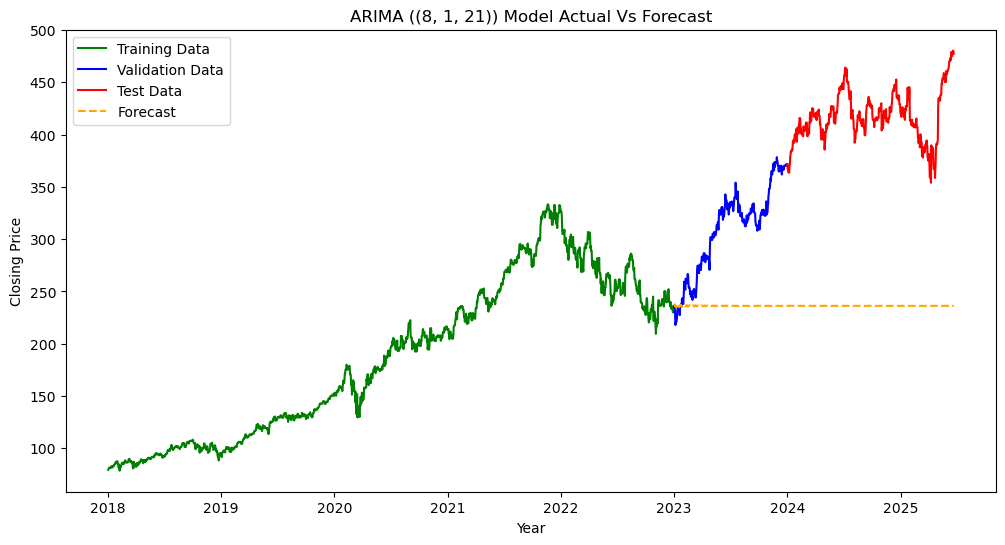

In [109]:
plt.figure(figsize = (12,6))
plt.plot(df_train['close'], label = "Training Data", color = "Green")
plt.plot(df_val['close'], label = "Validation Data", color = "Blue")
plt.plot(df_test['close'], label = "Test Data", color = "Red")
plt.plot(arima_E2_forecast, label = "Forecast", linestyle = "--", color = "orange")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.title(f"ARIMA ({best_order}) Model Actual Vs Forecast")
plt.show()

<font color = "blue">(e) Evaluate Performance</font>

In [111]:
print("Performance evaluation on Training Data (Experiment 2)")
print(" ")

# Evaluation on Training Set
train_forecast = best_model.predict(start = df_train.index[0], end = df_train.index[-1], typ='levels')

# 1. RMSE
train_rmse = np.sqrt(mean_squared_error(df_train['close'], train_forecast))
print(f"Training RMSE: {train_rmse:.2f}")

# 2. MSE
train_mse = mean_squared_error(df_train['close'], train_forecast)
print(f"Training MSE: {train_mse:.2f}")

# 3. MAPE
train_mape = mean_absolute_percentage_error(df_train['close'], train_forecast)
print(f"Training MAPE: {train_mape:.2f}%")

Performance evaluation on Training Data (Experiment 2)
 
Training RMSE: 3.56
Training MSE: 12.70
Training MAPE: 1.07%


In [112]:
print("Performance evaluation on Validation Data (Experiment 2)")
print(" ")

# Evaluation on Validation Set
val_forecast = arima_E2_forecast[:val_steps]

# Metrics
# 1. RMSE
val_rmse = np.sqrt(mean_squared_error(df_val['close'], val_forecast))
print(f"Validation RMSE: {val_rmse:.2f}")

# 2. MSE
val_mse = mean_squared_error(df_val['close'], val_forecast)
print(f"Validation MSE: {val_mse:.2f}")

# 3. MAPE
val_mape = mean_absolute_percentage_error(df_val['close'], val_forecast)
print(f"Validation MAPE: {val_mape:.2f}%")

Performance evaluation on Validation Data (Experiment 2)
 
Validation RMSE: 84.00
Validation MSE: 7055.93
Validation MAPE: 22.48%


In [113]:
print("Performance evaluation on Test Data (Experiment 2)")
print(" ")

# Evaluation on Test Set
test_forecast = arima_E2_forecast[val_steps:]

# Metrics
# 1. RMSE
test_rmse = np.sqrt(mean_squared_error(df_test['close'], test_forecast))
print(f"Test RMSE: {test_rmse:.2f}")

# 2. MSE
test_mse = mean_squared_error(df_test['close'], test_forecast)
print(f"Test MSE: {test_mse:.2f}")

# 3. MAPE
test_mape = mean_absolute_percentage_error(df_test['close'], test_forecast)
print(f"Test MAPE: {test_mape:.2f}%")

Performance evaluation on Test Data (Experiment 2)
 
Test RMSE: 182.43
Test MSE: 33280.89
Test MAPE: 43.18%


This ARIMA Model with (8,1,21) order compared to (1,1,1) model perform slightly better but still it is overfitting. Hence, our next step would be to try **"Auto ARIMA"** model as it automates the selection of optimal (p,d,q) values (and seasonal terms, if needed) based on AIC/BIC, and often finds better models than manual tuning.

#### **Auto ARIMA**

<font color = "blue">(a) Fit the Auto ARIMA model on Training Data</font>

In [117]:
import warnings
warnings.simplefilter("ignore")

# Initialize the Auto ARIMA Model
auto_arima_model = auto_arima(df_train['close'], seasonal = False, stepwise = True)

In [118]:
# View the Best Model
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1825
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -4665.595
Date:                Thu, 26 Jun 2025   AIC                           9335.190
Time:                        12:07:54   BIC                           9346.207
Sample:                    01-02-2018   HQIC                          9339.254
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1135      0.015     -7.488      0.000      -0.143      -0.084
sigma2         9.7561      0.159     61.337      0.000       9.444      10.068
Ljung-Box (L1) (Q):                   0.01   Jarque-

<font color = "blue">(b) Forecast Into Validation and Test Periods</font>

In [120]:
# Fit the Model
auto_arima_model_fit = auto_arima_model.fit(df_train['close'])

# Forecast steps
val_steps = len(df_val)
test_steps = len(df_test)
total_steps = val_steps + test_steps

# Forecast
auto_arima_model_forecast = auto_arima_model.predict(n_periods=total_steps)
forecast_auto_index = pd.date_range(start=df_val.index[0], periods=total_steps, freq='D')

<font color = "blue">(c) Plot Forecast vs Actual</font>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'auto_arima Forecast vs Actual')

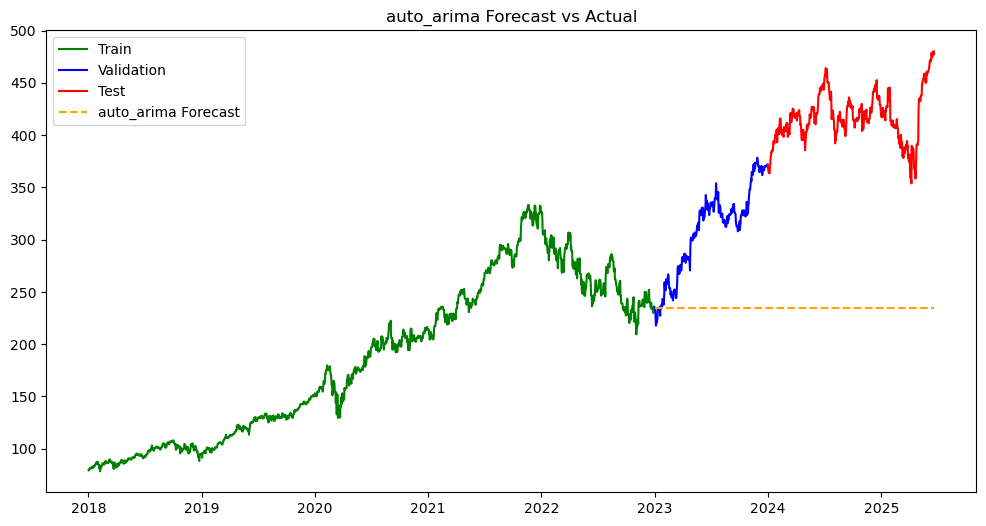

In [122]:
plt.figure(figsize=(12,6))
plt.plot(df_train['close'], label='Train', color = "green")
plt.plot(df_val['close'], label='Validation', color = "blue")
plt.plot(df_test['close'], label='Test', color = "red")
plt.plot(forecast_auto_index, auto_arima_model_forecast, label='auto_arima Forecast', linestyle='--', color = "orange")
plt.legend()
plt.title("auto_arima Forecast vs Actual")
plt.show()

<font color = "blue">(d) Evaluate Performance</font>

In [124]:
print("Performance evaluation on Training Data (Experiment 3)")
print(" ")

# Evaluation on Training Set
train_forecast = auto_arima_model.predict_in_sample()

# 1. RMSE
train_rmse = np.sqrt(mean_squared_error(df_train['close'], train_forecast))
print(f"Training RMSE: {train_rmse:.2f}")

# 2. MSE
train_mse = mean_squared_error(df_train['close'], train_forecast)
print(f"Training MSE: {train_mse:.2f}")

# 3. MAPE
train_mape = mean_absolute_percentage_error(df_train['close'], train_forecast)
print(f"Training MAPE: {train_mape:.2f}%")

Performance evaluation on Training Data (Experiment 3)
 
Training RMSE: 3.63
Training MSE: 13.20
Training MAPE: 1.01%


In [125]:
print("Performance evaluation on Validation Data (Experiment 3)")
print(" ")

# Evaluation on Validation Set
val_forecast = auto_arima_model_forecast[:val_steps]

# Metrics
# 1. RMSE
val_rmse = np.sqrt(mean_squared_error(df_val['close'], val_forecast))
print(f"Validation RMSE: {val_rmse:.2f}")

# 2. MSE
val_mse = mean_squared_error(df_val['close'], val_forecast)
print(f"Validation MSE: {val_mse:.2f}")

# 3. MAPE
val_mape = mean_absolute_percentage_error(df_val['close'], val_forecast)
print(f"Validation MAPE: {val_mape:.2f}%")

Performance evaluation on Validation Data (Experiment 3)
 
Validation RMSE: 84.99
Validation MSE: 7223.96
Validation MAPE: 22.79%


In [126]:
print("Performance evaluation on Test Data (Experiment 3)")
print(" ")

# Evaluation on Test Set
test_forecast = auto_arima_model_forecast[val_steps:]

# Metrics
# 1. RMSE
test_rmse = np.sqrt(mean_squared_error(df_test['close'], test_forecast))
print(f"Test RMSE: {test_rmse:.2f}")

# 2. MSE
test_mse = mean_squared_error(df_test['close'], test_forecast)
print(f"Test MSE: {test_mse:.2f}")

# 3. MAPE
test_mape = mean_absolute_percentage_error(df_test['close'], test_forecast)
print(f"Test MAPE: {test_mape:.2f}%")

Performance evaluation on Test Data (Experiment 3)
 
Test RMSE: 183.56
Test MSE: 33694.76
Test MAPE: 43.46%


#### **SARIMA**

In [128]:
import warnings
warnings.simplefilter("ignore")

# Initialize the Auto ARIMA Model
auto_sarima_model = auto_arima(df_train['close'], seasonal = True, m = 63, stepwise = True)

In [129]:
# View the Best Model
print(auto_sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1825
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -4665.595
Date:                Thu, 26 Jun 2025   AIC                           9335.190
Time:                        12:09:39   BIC                           9346.207
Sample:                    01-02-2018   HQIC                          9339.254
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1135      0.015     -7.488      0.000      -0.143      -0.084
sigma2         9.7561      0.159     61.337      0.000       9.444      10.068
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [130]:
# Fit the Model
auto_sarima_model_fit = auto_sarima_model.fit(df_train['close'])

# Forecast steps
val_steps = len(df_val)
test_steps = len(df_test)
total_steps = val_steps + test_steps

# Forecast
auto_sarima_model_forecast = auto_sarima_model.predict(n_periods=total_steps)
forecast_auto_s_index = pd.date_range(start=df_val.index[0], periods=total_steps, freq='D')

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'auto_sarima Forecast vs Actual')

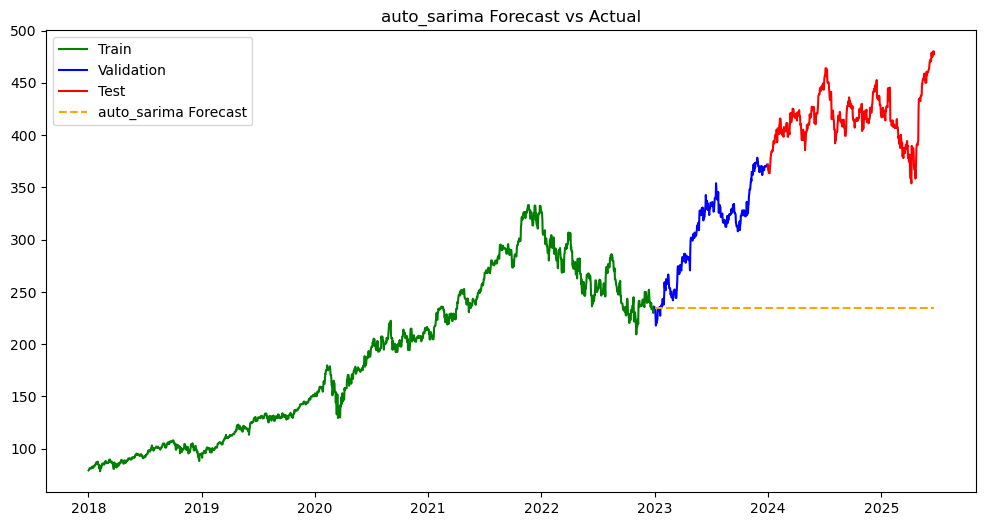

In [131]:
plt.figure(figsize=(12,6))
plt.plot(df_train['close'], label='Train', color = "green")
plt.plot(df_val['close'], label='Validation', color = "blue")
plt.plot(df_test['close'], label='Test', color = "red")
plt.plot(forecast_auto_s_index, auto_sarima_model_forecast, label='auto_sarima Forecast', linestyle='--', color = "orange")
plt.legend()
plt.title("auto_sarima Forecast vs Actual")
plt.show()

#### **Root Causes**

**Non-Stationarity in Variance (Heteroskedasticity)**

While the first-order differencing successfully made the data stationary in terms of the mean , the diagnostics show significant heteroskedasticity (non-constant variance) in the residuals. This means the volatility of the Microsoft stock price changes over time, a common characteristic of financial markets. ARIMA models assume constant variance, and this violation significantly impacts their predictive accuracy and the validity of their statistical inferences.

**Uncaptured Autocorrelation in Residuals**

The Ljung-Box test on the model's residuals indicates remaining autocorrelation (Prob(Q): 0.00). This suggests that the model has not fully captured all the underlying patterns and dependencies in the data, implying that there is still predictive information left in the errors.

**Non-Normally Distributed Residuals**

The Jarque-Bera test shows that the residuals are not normally distributed (Prob(JB): 0.00). This violates another key assumption of ARIMA models and can lead to unreliable confidence intervals and forecasts

**Poor Generalization (Overfitting)**

The model demonstrates significantly worse performance on the validation and test sets compared to the training set. This indicates that the ARIMA model is overfitting to the training data and failing to generalize to unseen data, which is typical when simple linear models try to capture complex, non-linear patterns in volatile stock data.

**Linearity Assumption**

ARIMA models are linear. Stock prices, however, are often influenced by non-linear relationships, external factors, and complex market dynamics that linear models struggle to adequately capture.

---------------------------------------------------------------------------------------------------------------------------------------------
#### **Actions to Improve**

**Address Heteroskedasticity with ARCH/GARCH Models**

Since stock price volatility is not constant, models specifically designed to handle conditional heteroskedasticity, such as AutoRegressive Conditional Heteroskedasticity (ARCH) or Generalized ARCH (GARCH) models, should be employed. Combining an ARIMA model with a GARCH model (e.g., ARIMA-GARCH) can capture both the conditional mean and conditional variance of the time series.

#### **ARIMA-GARCH Model**

<ul>
    <li>ARIMA: for modeling the mean of the series</li>
    <li>GARCH: for modeling the variance (volatility)</li>
</ul>

In [134]:
ag_df = msft_df[['close']]

ag_df

,close
2018-01-02,79.33
2018-01-03,79.70
2018-01-04,80.40
2018-01-05,81.40
2018-01-06,81.40
...,...
2025-06-16,479.14
2025-06-17,478.04
2025-06-18,480.24
2025-06-19,480.24


In [135]:
# log returns
ag_df['log_return'] = 100 * np.log(ag_df['close'] / ag_df['close'].shift(1))
ag_df = ag_df.dropna()
ag_df.head(10)

,close,log_return
2018-01-03,79.70,0.465322
2018-01-04,80.40,0.874459
2018-01-05,81.40,1.236110
2018-01-06,81.40,0.000000
2018-01-07,81.40,0.000000
2018-01-08,81.48,0.098232
2018-01-09,81.42,-0.073665
2018-01-10,81.05,-0.455469
2018-01-11,81.29,0.295676
2018-01-12,82.70,1.719659


In [136]:
# Train (2018 - 2022) & Test (2023-2025)
train_end = ag_df.index[ag_df.index < "2023-01-01"]
test_end = ag_df.index[ag_df.index >= "2023-01-01"]

train_data = ag_df.loc[train_end, 'log_return']
test_data = ag_df.loc[test_end, 'log_return']

In [137]:
# Fit ARIMA on training data
arima_model = ARIMA(train_data, order=(8,0,21)).fit()
residuals = arima_model.resid

In [138]:
# Fit GARCH on ARIMA residuals
garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
garch_fitted = garch_model.fit(disp='off')

In [139]:
# Forecasting ARIMA + GARCH

# Forecast horizon
horizon = len(test_data)

# ARIMA Forecast: Mean returns
arima_forecast = arima_model.get_forecast(steps=horizon)
mean_forecast = arima_forecast.predicted_mean

# GARCH Forecast: Volatility
garch_forecast = garch_fitted.forecast(start=0, horizon=horizon)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# 7. Combine Mean + Volatility
forecast_df = pd.DataFrame({
    "Date": test_data.index,
    "Mean_Return_Forecast": mean_forecast.values,
    "Volatility_Forecast": vol_forecast
}).set_index("Date")

forecast_df

,Mean_Return_Forecast,Volatility_Forecast
Date,,
2023-01-01,0.585995,1.394366
2023-01-02,0.105253,1.399564
2023-01-03,0.561622,1.404660
2023-01-04,-0.415313,1.409655
2023-01-05,0.397515,1.414551
...,...,...
2025-06-16,0.059694,1.685366
2025-06-17,0.059694,1.685366
2025-06-18,0.059694,1.685366


In [140]:
# Evaluate with MSE
mse = mean_squared_error(test_data, forecast_df["Mean_Return_Forecast"])
print(f"ARIMA-GARCH Forecast MSE on Test Set: {mse:.4f}")

ARIMA-GARCH Forecast MSE on Test Set: 1.5836


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'ARIMA-GARCH Forecast on Microsoft Stock Returns')

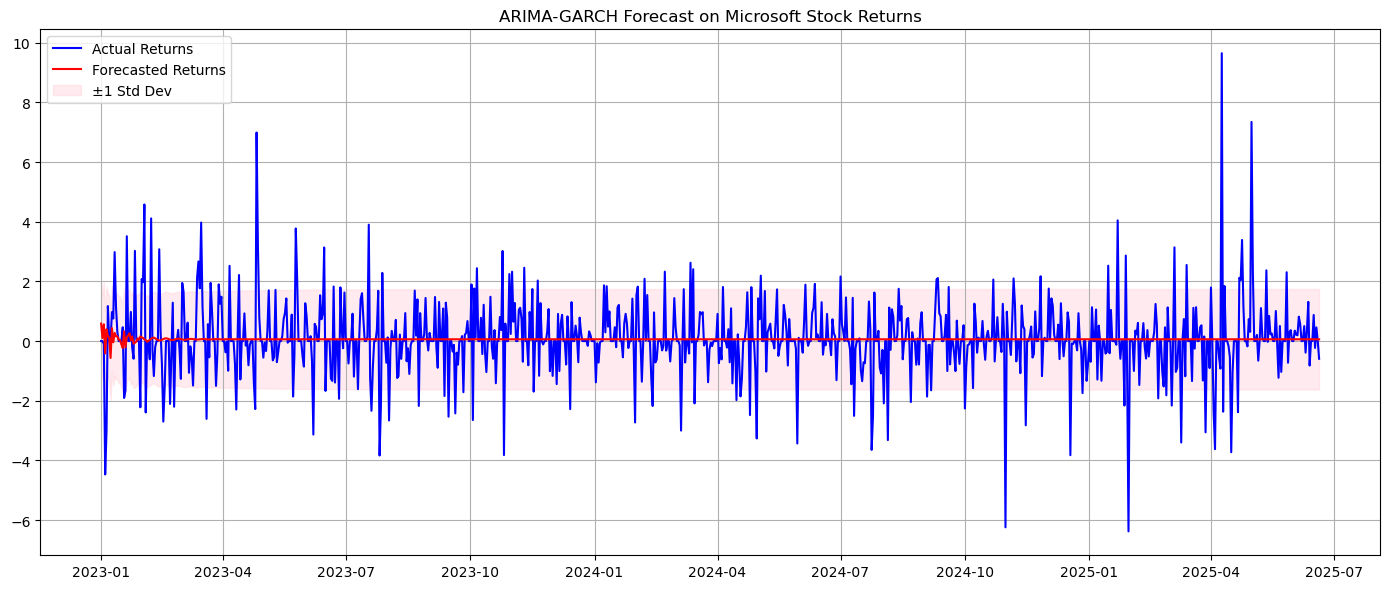

In [141]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data, label="Actual Returns", color='blue')
plt.plot(forecast_df.index, forecast_df["Mean_Return_Forecast"], label="Forecasted Returns", color='red')
plt.fill_between(forecast_df.index,
                 forecast_df["Mean_Return_Forecast"] - forecast_df["Volatility_Forecast"],
                 forecast_df["Mean_Return_Forecast"] + forecast_df["Volatility_Forecast"],
                 color='pink', alpha=0.3, label='±1 Std Dev')
plt.title("ARIMA-GARCH Forecast on Microsoft Stock Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Price Forecast MSE on Test Set: 4693.4208


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'MSFT: Forecasted vs Actual Prices from ARIMA-GARCH Returns')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price ($)')

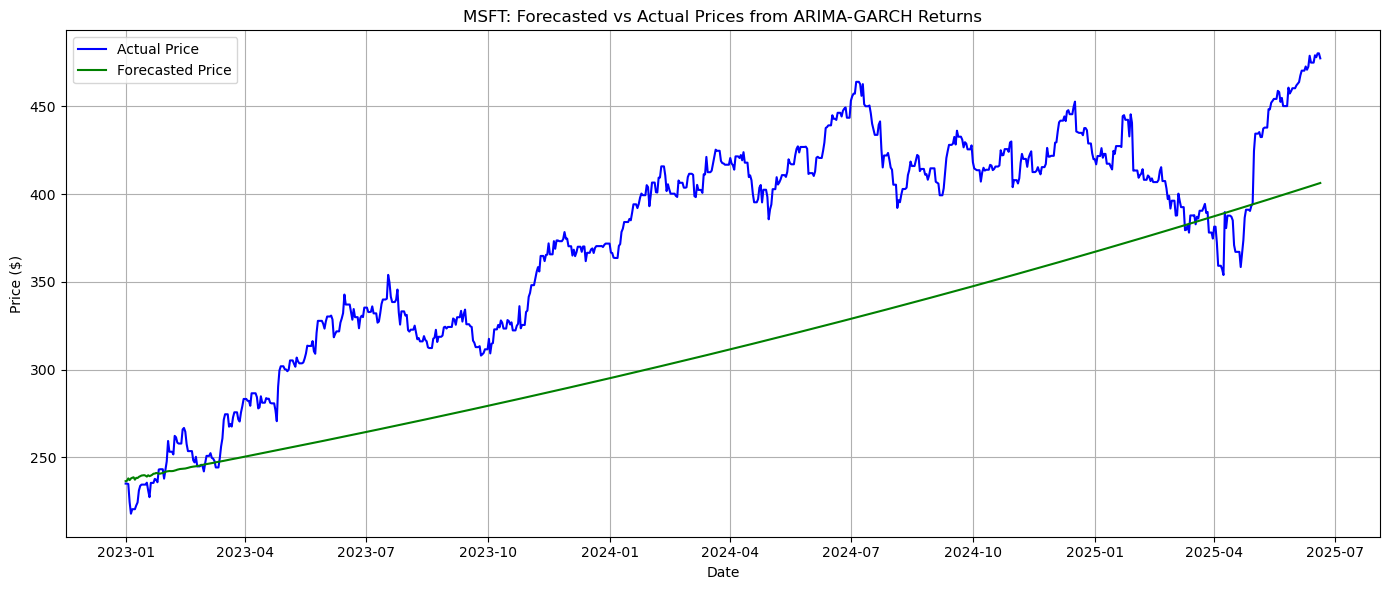

In [142]:
# Reconstruct Price Forecast from Log Returns

# 1. Get the last known actual price before the forecast
last_actual_price = ag_df.loc[ag_df.index < "2023-01-01", "close"].iloc[-1]

# 2. Convert cumulative log returns back to price
log_returns = forecast_df["Mean_Return_Forecast"].values
cum_log_return = np.cumsum(log_returns) / 100  # convert % to decimal
forecasted_prices = last_actual_price * np.exp(cum_log_return)

# 3. Add to forecast_df
forecast_df["Forecasted_Price"] = forecasted_prices

# 4. Actual prices for comparison
actual_test_prices = ag_df.loc[forecast_df.index, "close"]

# 5. Evaluate price-level forecast
price_mse = mean_squared_error(actual_test_prices, forecast_df["Forecasted_Price"])
print(f"Price Forecast MSE on Test Set: {price_mse:.4f}")

# 6. Plot: Actual vs Forecasted Prices
plt.figure(figsize=(14, 6))
plt.plot(actual_test_prices.index, actual_test_prices, label="Actual Price", color='blue')
plt.plot(forecast_df.index, forecast_df["Forecasted_Price"], label="Forecasted Price", color='green')
plt.title("MSFT: Forecasted vs Actual Prices from ARIMA-GARCH Returns")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The model appears to track the general upward trend of the actual test data (blue line) quite well initially. The ARIMA-GARCH model provided a reasonable short-to-medium term forecast for Microsoft stock prices. However, it struggled to capture a significant upward acceleration in the actual stock prices towards the end of the test period, indicating limitations in forecasting highly dynamic and non-linear market movements over longer horizons. This reinforces the previous discussion about the need for more complex models or additional features for highly accurate stock price prediction.

Since, traditional time-series models are difficult to capture the non-linear patterns, especially stock price. We will move to complex models like **XGBoost**.

Before we build the XGBoost model, let's add extra features.

#### **Feature Engineering**

In [147]:
# Dataset
feature_df = pd.read_csv("microsoft_stock_data.csv", index_col = 0, parse_dates = True)
feature_df = feature_df[["close"]]

# Adding missing dates
all_dates = pd.date_range(start = feature_df.index.min(), end = feature_df.index.max(), freq = "D")
feature_df = feature_df.reindex(all_dates)
feature_df["close"] = feature_df["close"].ffill()

# Glimpse of the Data
feature_df.head()

,close
1986-03-13,0.0596
1986-03-14,0.0617
1986-03-15,0.0617
1986-03-16,0.0617
1986-03-17,0.0628


In [148]:
# 1. Log returns
feature_df["log_return"] = np.log(feature_df["close"] / feature_df["close"].shift(1))

In [149]:
# 2. Moving Averages
feature_df["ma_10"] = feature_df["close"].rolling(window=10).mean()
feature_df["ma_20"] = feature_df["close"].rolling(window=20).mean()
feature_df["ma_50"] = feature_df["close"].rolling(window=50).mean()

In [150]:
# 3. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close = feature_df["close"], window=20, window_dev=2)

feature_df["bb_bbm"] = bollinger.bollinger_mavg()
feature_df["bb_bbh"] = bollinger.bollinger_hband()
feature_df["bb_bbl"] = bollinger.bollinger_lband()

In [151]:
# 4. RSI
feature_df["RSI"] = ta.momentum.RSIIndicator(close = feature_df["close"], window=14).rsi()

In [152]:
# 5. MACD
macd = ta.trend.MACD(close = feature_df["close"])
feature_df["MACD"] = macd.macd()
feature_df["MACD_signal"] = macd.macd_signal()

In [153]:
# 6. Rolling Volatility
feature_df["rolling_std_7"] = feature_df["close"].rolling(window=7).std()
feature_df["rolling_std_21"] = feature_df["close"].rolling(window=21).std()

In [154]:
# 7. Lag Features
feature_df["lag_1"] = feature_df["close"].shift(1)
feature_df["lag_2"] = feature_df["close"].shift(2)
feature_df["lag_3"] = feature_df["close"].shift(3)

In [155]:
# 8. Time Features
feature_df["day_of_week"] = feature_df.index.dayofweek
feature_df["month"] = feature_df.index.month
feature_df["quarter"] = feature_df.index.quarter
feature_df["is_month_start"] = feature_df.index.is_month_start.astype(int)
feature_df["is_month_end"] = feature_df.index.is_month_end.astype(int)

In [156]:
# Remove the NaN
feature_df = feature_df.dropna()

# Glimpse of the Data
feature_df.head(20)

,close,log_return,ma_10,ma_20,ma_50,bb_bbm,bb_bbh,bb_bbl,RSI,MACD,...,rolling_std_7,rolling_std_21,lag_1,lag_2,lag_3,day_of_week,month,quarter,is_month_start,is_month_end
1986-05-01,0.0676,-0.016141,0.06850,0.065415,0.061640,0.065415,0.073871,0.056959,58.797842,0.002620,...,0.001870,0.004327,0.0687,0.0703,0.0724,3,5,2,1,0
1986-05-02,0.0676,0.000000,0.06914,0.065735,0.061800,0.065735,0.074011,0.057459,58.797842,0.002409,...,0.002092,0.004255,0.0676,0.0687,0.0703,4,5,2,0,0
1986-05-03,0.0676,0.000000,0.06975,0.066055,0.061918,0.066055,0.074097,0.058013,58.797842,0.002216,...,0.002092,0.004158,0.0676,0.0676,0.0687,5,5,2,0,0
1986-05-04,0.0676,0.000000,0.06975,0.066350,0.062036,0.066350,0.074161,0.058539,58.797842,0.002040,...,0.001870,0.004035,0.0676,0.0676,0.0676,6,5,2,0,0
1986-05-05,0.0671,-0.007424,0.06927,0.066620,0.062144,0.066620,0.074137,0.059103,56.361159,0.001838,...,0.001095,0.003909,0.0676,0.0676,0.0676,0,5,2,0,0
1986-05-06,0.0676,0.007424,0.06884,0.066805,0.062240,0.066805,0.074226,0.059384,58.225534,0.001700,...,0.000485,0.003764,0.0671,0.0676,0.0676,1,5,2,0,0
1986-05-07,0.0676,0.000000,0.06841,0.066965,0.062368,0.066965,0.074310,0.059620,58.225534,0.001572,...,0.000189,0.003715,0.0676,0.0671,0.0676,2,5,2,0,0
1986-05-08,0.0681,0.007369,0.06798,0.067255,0.062528,0.067255,0.074292,0.060218,60.197674,0.001493,...,0.000289,0.003681,0.0676,0.0676,0.0671,3,5,2,0,0
1986-05-09,0.0676,-0.007369,0.06771,0.067520,0.062708,0.067520,0.074179,0.060861,57.285252,0.001375,...,0.000289,0.003519,0.0681,0.0676,0.0676,4,5,2,0,0
1986-05-10,0.0676,0.000000,0.06760,0.067785,0.062920,0.067785,0.073999,0.061571,57.285252,0.001266,...,0.000289,0.003330,0.0676,0.0681,0.0676,5,5,2,0,0


In [157]:
feature_df = feature_df.loc["2018" :]

feature_df.head()

,close,log_return,ma_10,ma_20,ma_50,bb_bbm,bb_bbh,bb_bbl,RSI,MACD,...,rolling_std_7,rolling_std_21,lag_1,lag_2,lag_3,day_of_week,month,quarter,is_month_start,is_month_end
2018-01-01,78.9501,0.000000,78.96118,79.137015,77.859002,79.137015,80.144949,78.129081,55.393768,0.318362,...,0.102925,0.505029,78.9501,78.9501,78.9501,0,1,1,1,0
2018-01-02,79.3285,0.004781,79.00179,79.164700,77.904030,79.164700,80.161674,78.167726,60.165316,0.324259,...,0.144410,0.505696,78.9501,78.9501,78.9501,1,1,1,0,0
2018-01-03,79.6977,0.004643,79.07932,79.241305,77.954238,79.241305,80.151064,78.331546,64.190263,0.354636,...,0.286116,0.511876,79.3285,78.9501,78.9501,2,1,1,0,0
2018-01-04,80.3992,0.008763,79.22700,79.253305,78.030476,79.253305,80.215970,78.290640,70.325518,0.430355,...,0.555979,0.520345,79.6977,79.3285,78.9501,3,1,1,0,0
2018-01-05,81.3960,0.012322,79.48451,79.315145,78.122588,79.315145,80.605698,78.024592,76.489467,0.564291,...,0.929419,0.671049,80.3992,79.6977,79.3285,4,1,1,0,0


In [159]:
# Dataset
lstm_df = feature_df.copy()

# Glimpse of the Data
lstm_df.head()

,close,log_return,ma_10,ma_20,ma_50,bb_bbm,bb_bbh,bb_bbl,RSI,MACD,...,rolling_std_7,rolling_std_21,lag_1,lag_2,lag_3,day_of_week,month,quarter,is_month_start,is_month_end
2018-01-01,78.9501,0.000000,78.96118,79.137015,77.859002,79.137015,80.144949,78.129081,55.393768,0.318362,...,0.102925,0.505029,78.9501,78.9501,78.9501,0,1,1,1,0
2018-01-02,79.3285,0.004781,79.00179,79.164700,77.904030,79.164700,80.161674,78.167726,60.165316,0.324259,...,0.144410,0.505696,78.9501,78.9501,78.9501,1,1,1,0,0
2018-01-03,79.6977,0.004643,79.07932,79.241305,77.954238,79.241305,80.151064,78.331546,64.190263,0.354636,...,0.286116,0.511876,79.3285,78.9501,78.9501,2,1,1,0,0
2018-01-04,80.3992,0.008763,79.22700,79.253305,78.030476,79.253305,80.215970,78.290640,70.325518,0.430355,...,0.555979,0.520345,79.6977,79.3285,78.9501,3,1,1,0,0
2018-01-05,81.3960,0.012322,79.48451,79.315145,78.122588,79.315145,80.605698,78.024592,76.489467,0.564291,...,0.929419,0.671049,80.3992,79.6977,79.3285,4,1,1,0,0


In [161]:
# Set Random Seeds for Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [162]:
base_df = lstm_df[['close']]

# Normalize the 'close' price
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(base_df)

### **XGBoost**

In [190]:
xgb_df = feature_df.copy()
xgb_df.head()

,close,log_return,ma_10,ma_20,ma_50,bb_bbm,bb_bbh,bb_bbl,RSI,MACD,...,rolling_std_7,rolling_std_21,lag_1,lag_2,lag_3,day_of_week,month,quarter,is_month_start,is_month_end
2018-01-01,78.9501,0.000000,78.96118,79.137015,77.859002,79.137015,80.144949,78.129081,55.393768,0.318362,...,0.102925,0.505029,78.9501,78.9501,78.9501,0,1,1,1,0
2018-01-02,79.3285,0.004781,79.00179,79.164700,77.904030,79.164700,80.161674,78.167726,60.165316,0.324259,...,0.144410,0.505696,78.9501,78.9501,78.9501,1,1,1,0,0
2018-01-03,79.6977,0.004643,79.07932,79.241305,77.954238,79.241305,80.151064,78.331546,64.190263,0.354636,...,0.286116,0.511876,79.3285,78.9501,78.9501,2,1,1,0,0
2018-01-04,80.3992,0.008763,79.22700,79.253305,78.030476,79.253305,80.215970,78.290640,70.325518,0.430355,...,0.555979,0.520345,79.6977,79.3285,78.9501,3,1,1,0,0
2018-01-05,81.3960,0.012322,79.48451,79.315145,78.122588,79.315145,80.605698,78.024592,76.489467,0.564291,...,0.929419,0.671049,80.3992,79.6977,79.3285,4,1,1,0,0


#### **Base Model**

In [192]:
# Create Lag Features
xgb_base = xgb_df[["close"]]

for lag in range(1,8):
    xgb_base[f'lag_{lag}'] = xgb_base['close'].shift(lag)

xgb_base.dropna(inplace = True)
xgb_base.head()

,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
2018-01-08,81.4790,81.3960,81.3960,81.3960,80.3992,79.6977,79.3285,78.9501
2018-01-09,81.4237,81.4790,81.3960,81.3960,81.3960,80.3992,79.6977,79.3285
2018-01-10,81.0545,81.4237,81.4790,81.3960,81.3960,81.3960,80.3992,79.6977
2018-01-11,81.2944,81.0545,81.4237,81.4790,81.3960,81.3960,81.3960,80.3992
2018-01-12,82.6974,81.2944,81.0545,81.4237,81.4790,81.3960,81.3960,81.3960


In [193]:
# Split the data into Train / Val / Test
X_base = xgb_base.drop('close', axis = 1)
y_base = xgb_base['close']

Xb_trainval, Xb_test, yb_trainval, yb_test = train_test_split(X_base, y_base, test_size = 0.10, shuffle = False)
Xb_train, Xb_val, yb_train, yb_val = train_test_split(Xb_trainval, yb_trainval, test_size = 0.10, shuffle = False)

In [266]:
# Train the XGBoost Model (Base)
xgb_base_model = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.01, max_depth = 2, random_state = 42)
xgb_base_model.fit(Xb_train, yb_train, eval_set = [(Xb_val, yb_val)], verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [268]:
# Predictions
# Train Set
yb_train_pred = xgb_base_model.predict(Xb_train)
mse_train_base, rmse_train_base, mape_train_base = evaluate_and_report(yb_train, yb_train_pred, label = "Train Base Model")

# Val Set
yb_val_pred = xgb_base_model.predict(Xb_val)
mse_val_base, rmse_val_base, mape_val_base = evaluate_and_report(yb_val, yb_val_pred, label = "Val Base Model")

# Test Set
yb_test_pred = xgb_base_model.predict(Xb_test)
mse_test_base, rmse_test_base, mape_test_base = evaluate_and_report(yb_test, yb_test_pred, label = "Test Base Model")

Train Base Model MSE:  8.81, RMSE: 2.97, MAPE: 0.94%
Val Base Model MSE:  1328.92, RMSE: 36.45, MAPE: 7.62%
Test Base Model MSE:  1907.85, RMSE: 43.68, MAPE: 8.40%


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'XGBoost Test Prediction (Baseline) Model')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Stock Price')

(array([19997., 20028., 20058., 20089., 20120., 20148., 20179., 20209.,
        20240., 20270.]),
 [Text(19997.0, 0, '2024-10'),
  Text(20028.0, 0, '2024-11'),
  Text(20058.0, 0, '2024-12'),
  Text(20089.0, 0, '2025-01'),
  Text(20120.0, 0, '2025-02'),
  Text(20148.0, 0, '2025-03'),
  Text(20179.0, 0, '2025-04'),
  Text(20209.0, 0, '2025-05'),
  Text(20240.0, 0, '2025-06'),
  Text(20270.0, 0, '2025-07')])

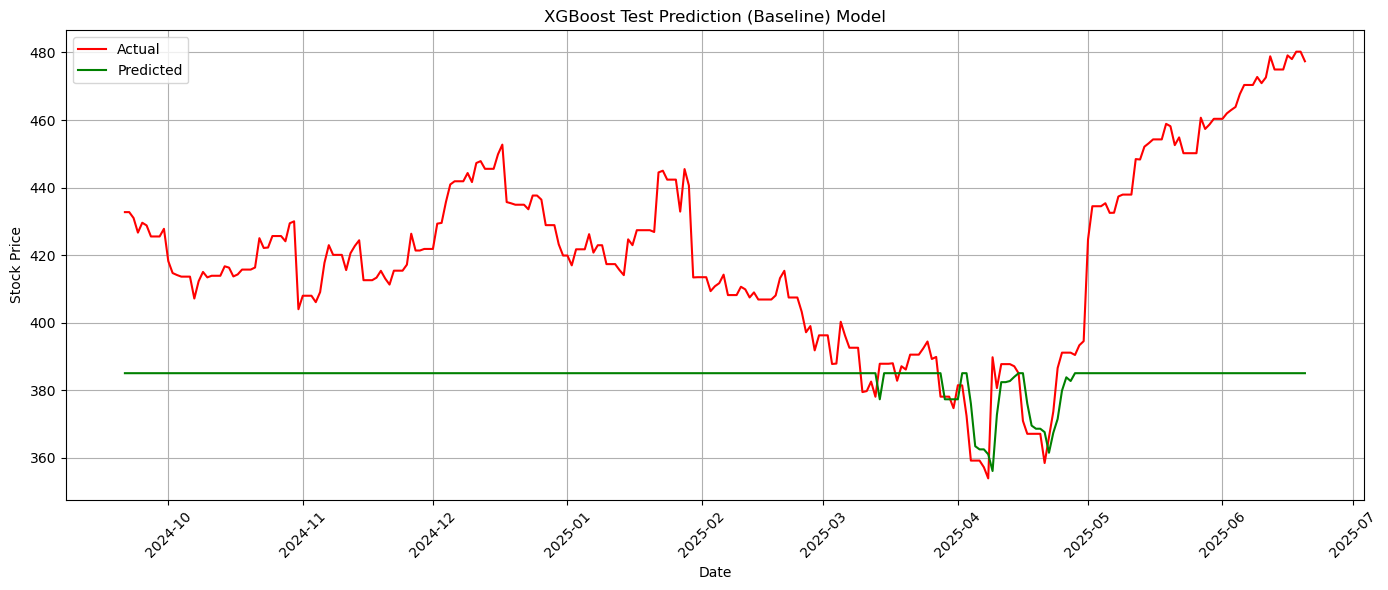

In [270]:
test_dates = xgb_base.index[-len(yb_test):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, yb_test, label="Actual", color="red")
plt.plot(test_dates, yb_test_pred, label="Predicted", color="green")
plt.title("XGBoost Test Prediction (Baseline) Model")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations and Interpretations**

1. The most striking feature of this plot is that the green "Predicted" line is almost entirely flat, or shows very minimal change, throughout the entire test period. It's essentially predicting a constant value (or a very slowly moving average) rather than capturing any of the dynamic movements of the actual stock price.

2. The model completely fails to track any of the actual price fluctuations, whether they are minor daily changes or major rallies and drops.

3. The red "Actual" line moves significantly from around 430 to over 480 and back down, while the predicted line remains stubbornly around $385. This visual discrepancy clearly illustrates the very high RMSE and MAPE values on the test set.

#### **Model with All Features**

In [212]:
xgb_all = xgb_df.copy()

Xf_all = xgb_all.drop('close', axis = 1)
yf_all = xgb_all['close']

Xa_trainval, Xa_test, ya_trainval, ya_test = train_test_split(Xf_all, yf_all, test_size=0.10, shuffle=False)
Xa_train, Xa_val, ya_train, ya_val = train_test_split(Xa_trainval, ya_trainval, test_size=0.10, shuffle=False)

In [296]:
# Train the XGBoost Model (All Features)
xgb_all_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
xgb_all_model.fit(Xa_train, ya_train, eval_set=[(Xa_val, ya_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [298]:
# Predictions
# Train Set
ya_train_pred = xgb_all_model.predict(Xa_train)
mse_train_all, rmse_train_all, mape_train_all = evaluate_and_report(ya_train, ya_train_pred, label = "Train (All Features) Model")

# Val Set
ya_val_pred = xgb_all_model.predict(Xa_val)
mse_val_all, rmse_val_all, mape_val_all = evaluate_and_report(ya_val, ya_val_pred, label = "Val (All Features) Model")

# Test Set
ya_test_pred = xgb_all_model.predict(Xa_test)
mse_test_all, rmse_test_all, mape_test_all = evaluate_and_report(ya_test, ya_test_pred, label = "Test (All Features) Model")

Train (All Features) Model MSE:  0.20, RMSE: 0.45, MAPE: 0.18%
Val (All Features) Model MSE:  1865.05, RMSE: 43.19, MAPE: 9.53%
Test (All Features) Model MSE:  2413.17, RMSE: 49.12, MAPE: 10.10%


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'XGBoost Test Prediction (All Features) Model')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Stock Price')

(array([19997., 20028., 20058., 20089., 20120., 20148., 20179., 20209.,
        20240., 20270.]),
 [Text(19997.0, 0, '2024-10'),
  Text(20028.0, 0, '2024-11'),
  Text(20058.0, 0, '2024-12'),
  Text(20089.0, 0, '2025-01'),
  Text(20120.0, 0, '2025-02'),
  Text(20148.0, 0, '2025-03'),
  Text(20179.0, 0, '2025-04'),
  Text(20209.0, 0, '2025-05'),
  Text(20240.0, 0, '2025-06'),
  Text(20270.0, 0, '2025-07')])

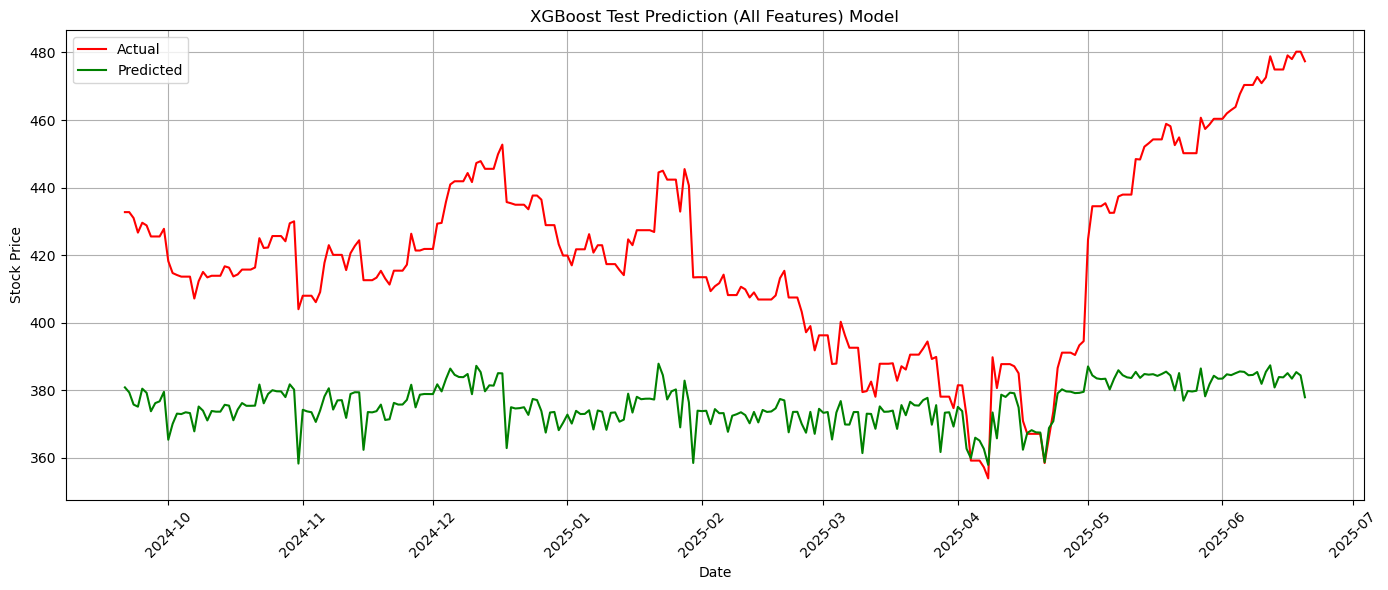

In [300]:
test_dates = xgb_base.index[-len(ya_test):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, ya_test, label="Actual", color="red")
plt.plot(test_dates, ya_test_pred, label="Predicted", color="green")
plt.title("XGBoost Test Prediction (All Features) Model")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations and Interpretations**

1. The green "Predicted" line is still largely disconnected from the red "Actual" line. While it shows more internal fluctuations than the flat line of the previous XGBoost baseline, these fluctuations do not consistently align with the actual price movements. Instead, they seem almost like noise.

2. For large portions of the test period, especially during the significant rally from late April/early May 2025, the predicted line remains far below the actual prices, reinforcing the high RMSE values.

3. The model fails to capture any meaningful trend or pattern in the actual test data.

#### **Feature Importance**

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 20 artists>

Text(0.5, 0, 'Permutation Importance (mean ΔRMSE)')

Text(0.5, 1.0, 'Permutation Feature Importance (Validation Set)')

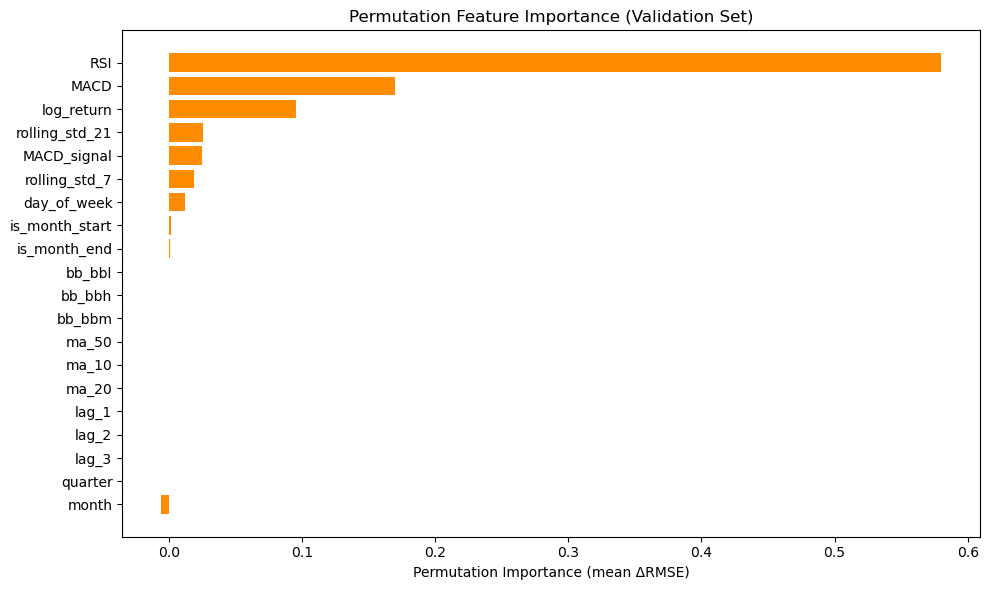

In [308]:
perm_result = permutation_importance(
    xgb_all_model, Xa_val, ya_val,
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)

# Convert to DataFrame
perm_df = pd.DataFrame({
    'Feature': Xa_val.columns,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'], perm_df['Importance'], color='darkorange')
plt.xlabel("Permutation Importance (mean ΔRMSE)")
plt.title("Permutation Feature Importance (Validation Set)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [310]:
# Choose a threshold (adjust if needed)
threshold = 0.01

# Select features above the threshold
top_features = perm_df[perm_df['Importance'] > threshold]['Feature'].tolist()

print(f"Selected {len(top_features)} important features:\n", top_features)

xgb_selected = xgb_all[top_features + ['close']].dropna()

X_sel = xgb_selected.drop('close', axis=1)
y_sel = xgb_selected['close']

# Train/val/test split
Xs_trainval, Xs_test, ys_trainval, ys_test = train_test_split(X_sel, y_sel, test_size=0.15, shuffle=False)
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs_trainval, ys_trainval, test_size=0.1765, shuffle=False)

Selected 7 important features:
 ['RSI', 'MACD', 'log_return', 'rolling_std_21', 'MACD_signal', 'rolling_std_7', 'day_of_week']


In [316]:
xgb_sel_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

xgb_sel_model.fit(Xs_train, ys_train, eval_set=[(Xs_val, ys_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [318]:
# Predictions
# Train Set
ys_train_pred = xgb_sel_model.predict(Xs_train)
mse_train_sel, rmse_train_sel, mape_train_sel = evaluate_and_report(ys_train, ys_train_pred, label = "Train (Selected Features) Model")

# Val Set
ys_val_pred = xgb_sel_model.predict(Xs_val)
mse_val_sel, rmse_val_sel, mape_val_sel = evaluate_and_report(ys_val, ys_val_pred, label = "Val (Selected Features) Model")

# Test Set
ys_test_pred = xgb_sel_model.predict(Xs_test)
mse_test_sel, rmse_test_sel, mape_test_sel = evaluate_and_report(ys_test, ys_test_pred, label = "Test (Selected Features) Model")

Train (Selected Features) Model MSE:  1038.38, RMSE: 32.22, MAPE: 14.42%
Val (Selected Features) Model MSE:  15139.81, RMSE: 123.04, MAPE: 29.58%
Test (Selected Features) Model MSE:  28416.39, RMSE: 168.57, MAPE: 39.40%


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'XGBoost Test Prediction (Selected Features) Model')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Stock Price')

(array([19844., 19905., 19967., 20028., 20089., 20148., 20209., 20270.]),
 [Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03'),
  Text(20209.0, 0, '2025-05'),
  Text(20270.0, 0, '2025-07')])

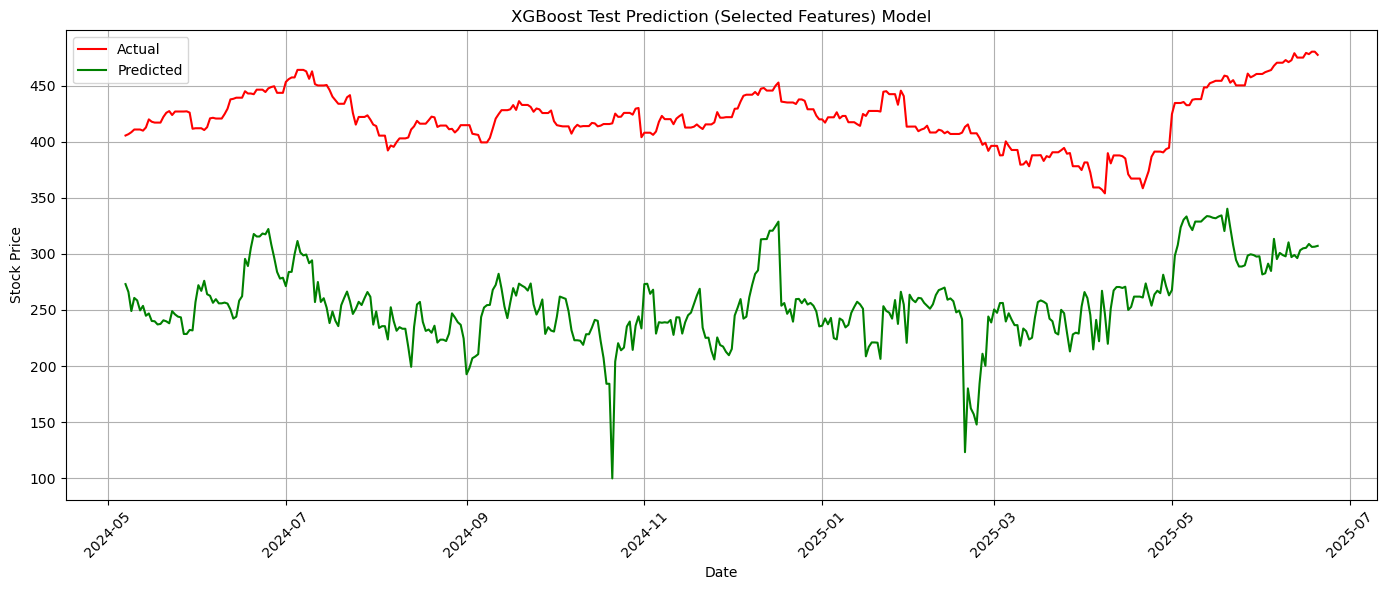

In [322]:
test_dates = xgb_selected.index[-len(ys_test):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, ys_test, label="Actual", color="red")
plt.plot(test_dates, ys_test_pred, label="Predicted", color="green")
plt.title("XGBoost Test Prediction (Selected Features) Model")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations and Interpretations**

1. The green "Predicted" line is consistently and dramatically lower than the red "Actual" line for almost the entire test period. There's no meaningful tracking of the actual price trend or fluctuations.

2. The predicted line appears to hover around a much lower price range (mostly 200-350) than the actual stock (mostly 350-480). It shows some spikes, but these do not correlate with actual price movements.

As this model doesn't remember temporal patterns natively, next we will move to deep learning model like **LSTM**.

### **LSTM**

#### **Base Model**

In [163]:
# Create Sequence
X, y = create_sequences(scaled_close, window = 60)

In [164]:
# Train-test split (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [165]:
# Build Base LSTM model
base_model = Sequential()
base_model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
base_model.add(Dense(1))
base_model.compile(optimizer='adam', loss='mse')

# Fit the Model
base_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0342 - val_loss: 4.9475e-04
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4239e-04 - val_loss: 4.1826e-04
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6875e-04 - val_loss: 3.4236e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5184e-04 - val_loss: 3.0986e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3900e-04 - val_loss: 3.0179e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2949e-04 - val_loss: 3.0126e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2244e-04 - val_loss: 3.0083e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1697e-04 - val_loss: 2.9863e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1235e-04 - val_loss: 2.9334e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0814e-04 - val_loss: 2.8469e-04


In [166]:
# Train Predictions
train_predictions = base_model.predict(X_train)
train_pred_inv = scaler.inverse_transform(train_predictions)
y_train_inv = scaler.inverse_transform(y_train)

# Metrics
train_mse = mean_squared_error(y_train_inv, train_pred_inv)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train_inv, train_pred_inv)

print("Train MSE: {}".format(train_mse))
print("Train RMSE: {}".format(train_rmse))
print("Train MAPE: {}%".format(train_mape))

# Validation Predictions
val_split = int(0.9 * len(X_train))  # 90% of training used for training, 10% for validation
X_val = X_train[val_split:]
y_val = y_train[val_split:]

val_predictions = base_model.predict(X_val)
val_pred_inv = scaler.inverse_transform(val_predictions)
y_val_inv = scaler.inverse_transform(y_val)

# Metrics
val_mse = mean_squared_error(y_val_inv, val_pred_inv)
val_rmse = np.sqrt(val_mse)
val_mape = mean_absolute_percentage_error(y_val_inv, val_pred_inv)

print("Val MSE: {}".format(val_mse))
print("Val RMSE: {}".format(val_rmse))
print("Val MAPE: {}%".format(val_mape))

# Test Predictions
test_predictions = base_model.predict(X_test)
test_pred_inv = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Metrics
test_mse = mean_squared_error(y_test_inv, test_pred_inv)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test_inv, test_pred_inv)

print("Test MSE: {}".format(test_mse))
print("Test RMSE: {}".format(test_rmse))
print("Test MAPE: {}%".format(test_mape))

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MSE: 34.97030853906672
Train RMSE: 5.913569864224716
Train MAPE: 1.9932946575665411%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Val MSE: 45.95595128982521
Val RMSE: 6.779081891364435
Val MAPE: 1.5995161145659158%
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MSE: 159.75589682521755
Test RMSE: 12.639457932412194
Test MAPE: 2.4597796053093446%


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

Text(0.5, 1.0, 'Baseline LSTM (Only Close)')

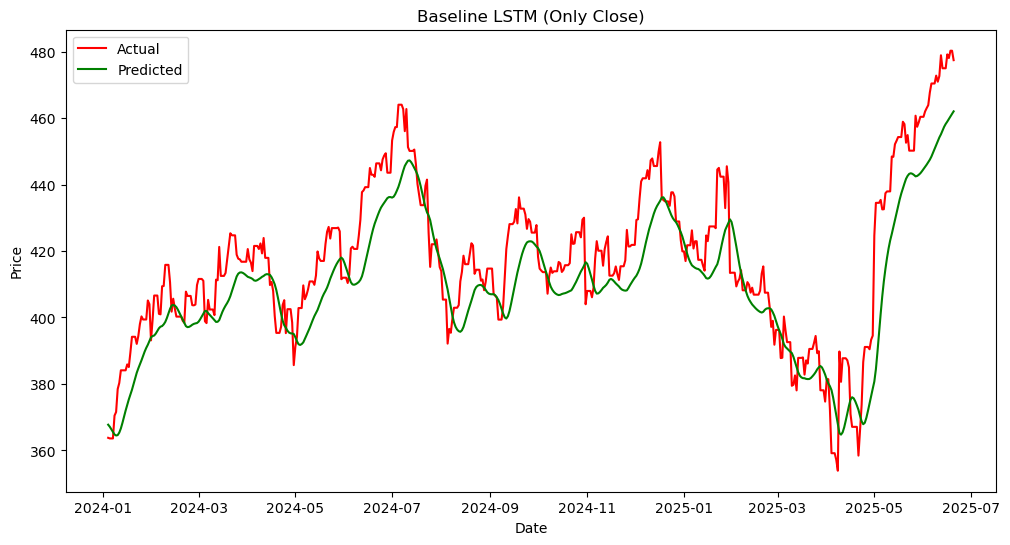

In [167]:
# Plot
dates = base_df.index[-len(y_test):]  # or df.index[-len(X_test):] if same length

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label="Actual", color = "Red")
plt.plot(dates, test_pred_inv, label="Predicted", color = "Green")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Baseline LSTM (Only Close)")
plt.show()

**Key Observations and Interpretation:**

1. **General Trend Following** - The green "Predicted" line generally follows the overall trend of the red "Actual" line. This indicates that your LSTM model has learned to capture the basic direction of the stock price movements. When the actual price goes up, the predicted price also tends to go up, and vice-versa.

2. **Lag in Predictions** - There's a noticeable lag in the predicted prices compared to the actual prices. The green line often trails the red line, especially during sharp upward or downward movements. This means the model reacts to changes in the actual price after they have already occurred. This is a common characteristic of basic time series models, including simple LSTMs, when dealing with highly volatile data, as they rely on past observations.

3. **Smoothing Effect** - The predicted line (green) appears smoother than the actual line (red). This smoothing effect means the model often misses the sharp peaks and troughs (extreme values) in the actual price movements. It tends to predict values that are closer to the average of recent prices rather than perfectly capturing sudden price jumps or drops.

4. **Underperformance in Volatile Periods** - Observe the periods of high volatility (e.g., the sharp drop in May 2025 and subsequent recovery). The model struggles to adapt quickly to these rapid changes, resulting in larger deviations between actual and predicted values during such times.

#### **Model with Features**

In [170]:
feat_df = lstm_df.copy()

# Target Column
target_col = "close"
window_size = 60

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(feat_df)

In [171]:
# Get index of 'Close' in scaled data
target_index = feat_df.columns.get_loc(target_col)

# Create Sequence
X_all, y_all = create_multifeature_sequences(scaled_data, target_index, window=window_size)

In [172]:
# Split the Data into Train (80%) / Val (10%) / Test Sets (10%)
n = len(X_all)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

In [173]:
feat_model = Sequential()
feat_model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
feat_model.add(Dense(1))
feat_model.compile(optimizer='adam', loss='mse')

feat_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0122 - val_loss: 0.0052
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4968e-04 - val_loss: 0.0025
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.2627e-04 - val_loss: 0.0025
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9982e-04 - val_loss: 0.0019
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6936e-04 - val_loss: 0.0016
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5290e-04 - val_loss: 0.0013
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4400e-04 - val_loss: 0.0012
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3426e-04 - val_loss: 0.0010
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2880e-04 - val_loss: 8.7198e-04
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2436e-04 - val_loss: 7.4016e-04


In [174]:
# Train Data
y_train_pred_scaled = feat_model.predict(X_train)

y_train_pred = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_train_pred_scaled), target_index)),  # padding before
    y_train_pred_scaled,
    np.zeros((len(y_train_pred_scaled), scaled_data.shape[1] - target_index - 1))  # padding after
], axis=1))[:, target_index]

y_train_actual = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_train), target_index)),
    y_train.reshape(-1, 1),
    np.zeros((len(y_train), scaled_data.shape[1] - target_index - 1))
], axis=1))[:, target_index]

train_mse = mean_squared_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train_actual, y_train_pred)

print("Train MSE: {}".format(train_mse))
print("Train RMSE: {}".format(train_rmse))
print("Train MAPE: {}".format(train_mape))

# Validation Data
y_val_pred_scaled = feat_model.predict(X_val)

y_val_pred = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_val_pred_scaled), target_index)),  # padding before
    y_val_pred_scaled,
    np.zeros((len(y_val_pred_scaled), scaled_data.shape[1] - target_index - 1))  # padding after
], axis=1))[:, target_index]

y_val_actual = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_val), target_index)),
    y_val.reshape(-1, 1),
    np.zeros((len(y_val), scaled_data.shape[1] - target_index - 1))
], axis=1))[:, target_index]

val_mse = mean_squared_error(y_val_actual, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mape = mean_absolute_percentage_error(y_val_actual, y_val_pred)

print("Val MSE: {}".format(val_mse))
print("Val RMSE: {}".format(val_rmse))
print("Val MAPE: {}".format(val_mape))

# Test Data
y_test_pred_scaled = feat_model.predict(X_test)

y_test_pred = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_test_pred_scaled), target_index)),  # padding before
    y_test_pred_scaled,
    np.zeros((len(y_test_pred_scaled), scaled_data.shape[1] - target_index - 1))  # padding after
], axis=1))[:, target_index]

y_test_actual = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_test), target_index)),
    y_test.reshape(-1, 1),
    np.zeros((len(y_test), scaled_data.shape[1] - target_index - 1))
], axis=1))[:, target_index]

test_mse = mean_squared_error(y_test_actual, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)

print("Test MSE: {}".format(test_mse))
print("Test RMSE: {}".format(test_rmse))
print("Test MAPE: {}".format(test_mape))

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MSE: 18.9097971207534
Train RMSE: 4.348539653809472
Train MAPE: 1.7444222956100441
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Val MSE: 119.48072975088853
Val RMSE: 10.930724118323019
Val MAPE: 2.3405848901221047
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 180.3185851018766
Test RMSE: 13.428275581841348
Test MAPE: 2.6165604872356427


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'LSTM with Engineered Features')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([19997., 20028., 20058., 20089., 20120., 20148., 20179., 20209.,
        20240., 20270.]),
 [Text(19997.0, 0, '2024-10'),
  Text(20028.0, 0, '2024-11'),
  Text(20058.0, 0, '2024-12'),
  Text(20089.0, 0, '2025-01'),
  Text(20120.0, 0, '2025-02'),
  Text(20148.0, 0, '2025-03'),
  Text(20179.0, 0, '2025-04'),
  Text(20209.0, 0, '2025-05'),
  Text(20240.0, 0, '2025-06'),
  Text(20270.0, 0, '2025-07')])

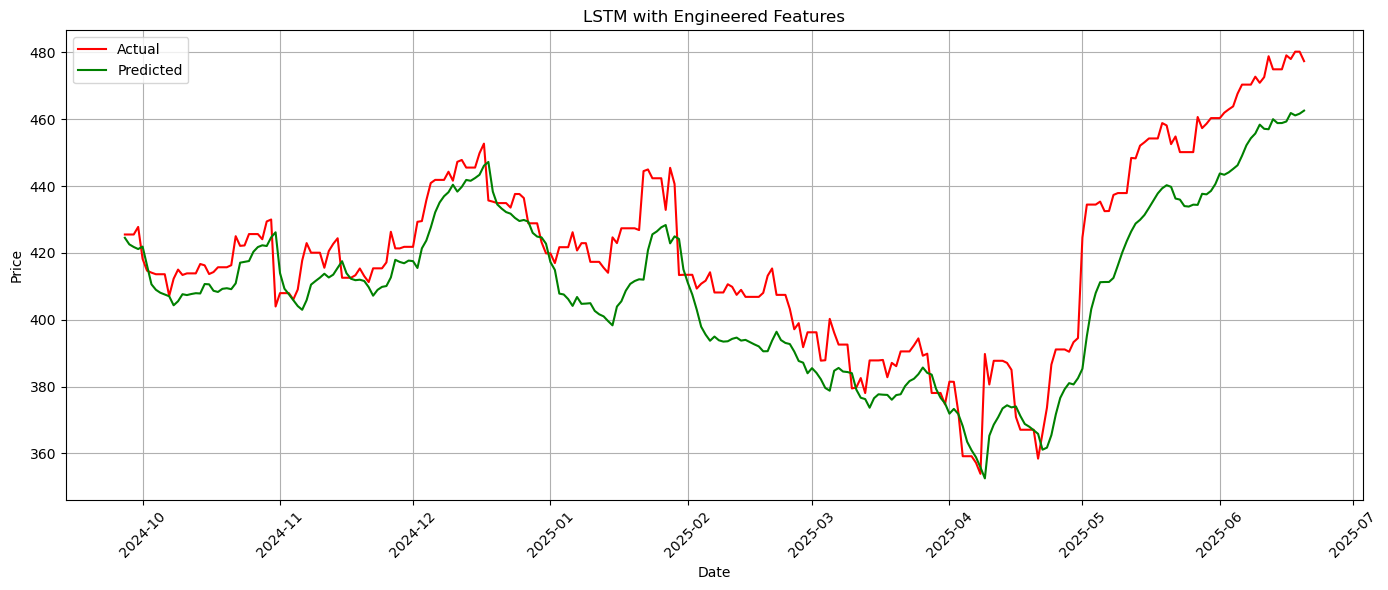

In [175]:
test_dates = feat_df.index[-len(y_test):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label="Actual", color='red')
plt.plot(test_dates, y_test_pred, label="Predicted", color='green')
plt.title("LSTM with Engineered Features")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Key Observations and Interpretation**

1. **Increased Volatility in Predictions**: Compared to the baseline plot, the green "Predicted" line is much more volatile and tries to follow the actual price movements more closely, especially the sharper turns.

2. **Wilder Swings and Mismatches**: While it tries to capture more detail, it also makes larger and more frequent deviations from the actual prices. For instance, notice the period around early to mid-2025. The actual price fluctuates, and the predicted line attempts to mimic these, but often with significant overshoots or undershoots, and still with a noticeable lag. The sharp drop in early 2025 is largely missed, and the recovery is then significantly underestimated.

3. **Failure to Capture Overall Trend**: In the later part of the plot (from around May 2025 onwards), the actual price experiences a strong, sustained rally, while the predicted price, despite trying to move up, consistently underestimates the actual value by a large margin.

The current set of engineered features, as implemented, has caused the LSTM model to overfit severely. The model is now much better at explaining the training data, but much worse at predicting new data. To address this overfitting and improve generalization, our next step would be to perform feature importance and consider those features which are contributing the most.

#### **Feature Importance**

In [178]:
# Test Data
baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# List of feature names in the same order
feature_names = feat_df.columns.tolist()

# Compute importances
importances = permutation_feature_importance(feat_model, X_test, y_test, baseline_rmse, feature_names)

# Display
for feat, drop in importances:
    print(f"{feat:20s} --> RMSE increase: {drop:.4f}")

  0%|                                                    | 0/21 [00:00<?, ?it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 10%|████▏                                       | 2/21 [00:00<00:01, 18.89it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██████████▍                                 | 5/21 [00:00<00:00, 20.07it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 38%|████████████████▊                           | 8/21 [00:00<00:00, 20.34it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 52%|██████████████████████▌                    | 11/21 [00:00<00:00, 20.47it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 67%|████████████████████████████▋              | 14/21 [00:00<00:00, 20.54it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 81%|██████████████████████████████████▊        | 17/21 [00:00<00:00, 20.66it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 95%|████████████████████████████████████████▉  | 20/21 [00:00<00:00, 20.78it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 20.53it/s]

MACD                 --> RMSE increase: 5.0380
RSI                  --> RMSE increase: 3.5950
ma_20                --> RMSE increase: 0.7797
close                --> RMSE increase: 0.7132
bb_bbh               --> RMSE increase: 0.6111
lag_1                --> RMSE increase: 0.5437
lag_3                --> RMSE increase: 0.4266
bb_bbm               --> RMSE increase: 0.4194
ma_10                --> RMSE increase: 0.4091
log_return           --> RMSE increase: 0.1974
quarter              --> RMSE increase: 0.1538
day_of_week          --> RMSE increase: 0.1052
ma_50                --> RMSE increase: 0.0906
MACD_signal          --> RMSE increase: 0.0872
is_month_start       --> RMSE increase: 0.0718
rolling_std_7        --> RMSE increase: 0.0558
is_month_end         --> RMSE increase: 0.0166
lag_2                --> RMSE increase: 0.0140
bb_bbl               --> RMSE increase: -0.1782
rolling_std_21       --> RMSE increase: -0.3634
month                --> RMSE increase: -0.4295


<Figure size 1200x600 with 0 Axes>

<BarContainer object of 21 artists>

Text(0.5, 0, 'Increase in RMSE when feature is permuted')

Text(0.5, 1.0, 'Permutation Feature Importance for LSTM Model')

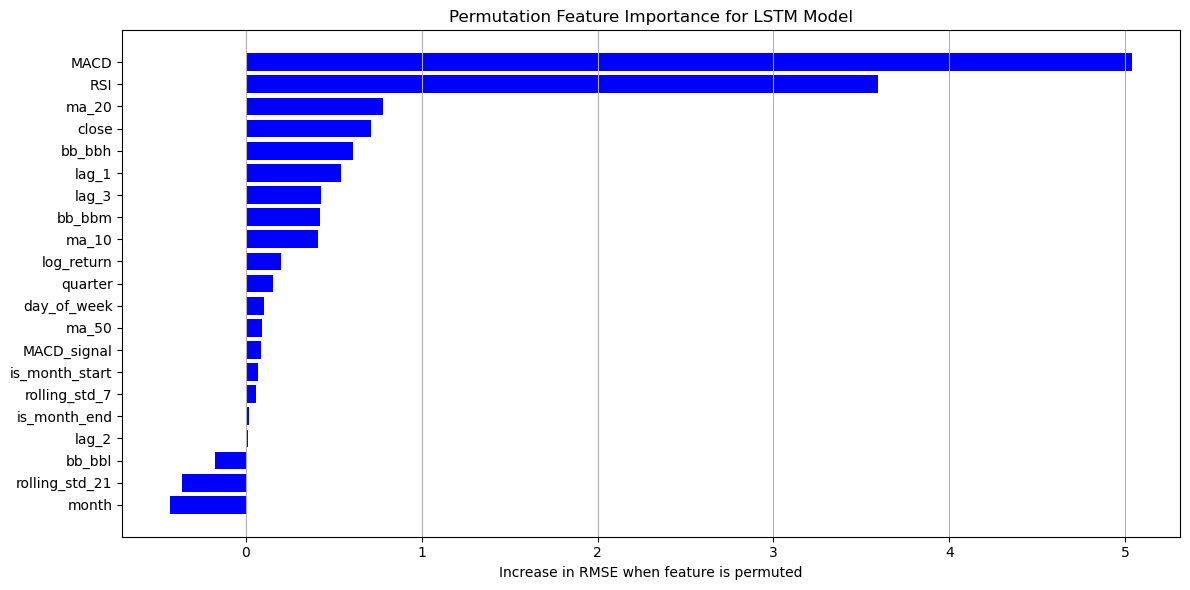

In [179]:
# Sort for plotting
features_sorted = [f for f, _ in importances]
drops_sorted = [d for _, d in importances]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(features_sorted, drops_sorted, color="blue")
plt.xlabel("Increase in RMSE when feature is permuted")
plt.title("Permutation Feature Importance for LSTM Model")
plt.gca().invert_yaxis()  # highest importance at top
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

Now, will build the LSTM model by only considering those features whose importance values > 0.

In [181]:
selected_features = ["RSI", "ma_10", "MACD", "lag_2", "close", "lag_1", "bb_bbm", "lag_3", "bb_bbh", "ma_20", "is_month_end",
                     "ma_50", "log_return", "day_of_week", "rolling_std_7"]


imp_feat_df = feat_df[selected_features]

# View the Data
imp_feat_df

,RSI,ma_10,MACD,lag_2,close,lag_1,bb_bbm,lag_3,bb_bbh,ma_20,is_month_end,ma_50,log_return,day_of_week,rolling_std_7
2018-01-01,55.393768,78.96118,0.318362,78.9501,78.9501,78.9501,79.137015,78.9501,80.144949,79.137015,0,77.859002,0.000000,0,0.102925
2018-01-02,60.165316,79.00179,0.324259,78.9501,79.3285,78.9501,79.164700,78.9501,80.161674,79.164700,0,77.904030,0.004781,1,0.144410
2018-01-03,64.190263,79.07932,0.354636,78.9501,79.6977,79.3285,79.241305,78.9501,80.151064,79.241305,0,77.954238,0.004643,2,0.286116
2018-01-04,70.325518,79.22700,0.430355,79.3285,80.3992,79.6977,79.253305,78.9501,80.215970,79.253305,0,78.030476,0.008763,3,0.555979
2018-01-05,76.489467,79.48451,0.564291,79.6977,81.3960,80.3992,79.315145,79.3285,80.605698,79.315145,0,78.122588,0.012322,4,0.929419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-16,75.849494,473.99400,8.009203,474.9600,479.1400,474.9600,468.196500,474.9600,481.688998,468.196500,0,451.451320,0.008762,0,3.003886
2025-06-17,73.107941,474.76000,7.849043,474.9600,478.0400,479.1400,469.230500,474.9600,482.408657,469.230500,0,453.203260,-0.002298,1,2.469281
2025-06-18,75.050277,475.74600,7.809613,479.1400,480.2400,478.0400,470.308500,474.9600,483.384994,470.308500,0,454.941700,0.004592,2,2.290116
2025-06-19,75.050277,476.49500,7.689721,478.0400,480.2400,480.2400,471.302500,479.1400,484.224379,471.302500,0,456.655780,0.000000,3,2.495027


In [182]:
scaler = MinMaxScaler()
scaled_selected = scaler.fit_transform(imp_feat_df)
target_col = "close"
target_index = imp_feat_df.columns.get_loc(target_col)
window_size = 60

In [183]:
# Create Sequence
X_all, y_all = create_multifeature_sequences(scaled_selected, target_index, window_size)

In [184]:
n = len(X_all)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

In [185]:
imp_feat_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

imp_feat_model.compile(optimizer="adam", loss="mse")
imp_feat_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - val_loss: 0.0012
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9198e-04 - val_loss: 0.0011
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3239e-04 - val_loss: 8.7928e-04
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9729e-04 - val_loss: 6.4561e-04
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6999e-04 - val_loss: 5.5476e-04
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4746e-04 - val_loss: 5.0135e-04
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3809e-04 - val_loss: 4.8083e-04
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3165e-04 - val_loss: 4.4921e-04
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3063e-04 - val_loss: 3.8296e-04
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2809e-04 - val_loss: 3.2349e-04


In [186]:
# Train Data
y_train_pred_scaled = imp_feat_model.predict(X_train)

y_train_pred = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_train_pred_scaled), target_index)),  # padding before
    y_train_pred_scaled,
    np.zeros((len(y_train_pred_scaled), scaled_selected.shape[1] - target_index - 1))  # padding after
], axis=1))[:, target_index]

y_train_actual = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_train), target_index)),
    y_train.reshape(-1, 1),
    np.zeros((len(y_train), scaled_selected.shape[1] - target_index - 1))
], axis=1))[:, target_index]

train_mse = mean_squared_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train_actual, y_train_pred)

print("Train MSE: {}".format(train_mse))
print("Train RMSE: {}".format(train_rmse))
print("Train MAPE: {}".format(train_mape))

# Validation Data
y_val_pred_scaled = imp_feat_model.predict(X_val)

y_val_pred = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_val_pred_scaled), target_index)),  # padding before
    y_val_pred_scaled,
    np.zeros((len(y_val_pred_scaled), scaled_selected.shape[1] - target_index - 1))  # padding after
], axis=1))[:, target_index]

y_val_actual = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_val), target_index)),
    y_val.reshape(-1, 1),
    np.zeros((len(y_val), scaled_selected.shape[1] - target_index - 1))
], axis=1))[:, target_index]

val_mse = mean_squared_error(y_val_actual, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mape = mean_absolute_percentage_error(y_val_actual, y_val_pred)

print("Val MSE: {}".format(val_mse))
print("Val RMSE: {}".format(val_rmse))
print("Val MAPE: {}".format(val_mape))

# Test Data
y_test_pred_scaled = imp_feat_model.predict(X_test)

y_test_pred = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_test_pred_scaled), target_index)),  # padding before
    y_test_pred_scaled,
    np.zeros((len(y_test_pred_scaled), scaled_selected.shape[1] - target_index - 1))  # padding after
], axis=1))[:, target_index]

y_test_actual = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_test), target_index)),
    y_test.reshape(-1, 1),
    np.zeros((len(y_test), scaled_selected.shape[1] - target_index - 1))
], axis=1))[:, target_index]

test_mse = mean_squared_error(y_test_actual, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test_actual, y_test_pred)

print("Test MSE: {}".format(test_mse))
print("Test RMSE: {}".format(test_rmse))
print("Test MAPE: {}".format(test_mape))

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MSE: 15.278252124199337
Train RMSE: 3.908740477980002
Train MAPE: 1.533666317647015
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Val MSE: 52.21949797601499
Val RMSE: 7.226305970273816
Val MAPE: 1.4213497481287962
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 90.94778539752247
Test RMSE: 9.536654832671804
Test MAPE: 1.8554202875687664


<Figure size 1400x600 with 0 Axes>

Text(0.5, 1.0, 'LSTM Test Prediction with Top Features Only')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Stock Price')

(array([19997., 20028., 20058., 20089., 20120., 20148., 20179., 20209.,
        20240., 20270.]),
 [Text(19997.0, 0, '2024-10'),
  Text(20028.0, 0, '2024-11'),
  Text(20058.0, 0, '2024-12'),
  Text(20089.0, 0, '2025-01'),
  Text(20120.0, 0, '2025-02'),
  Text(20148.0, 0, '2025-03'),
  Text(20179.0, 0, '2025-04'),
  Text(20209.0, 0, '2025-05'),
  Text(20240.0, 0, '2025-06'),
  Text(20270.0, 0, '2025-07')])

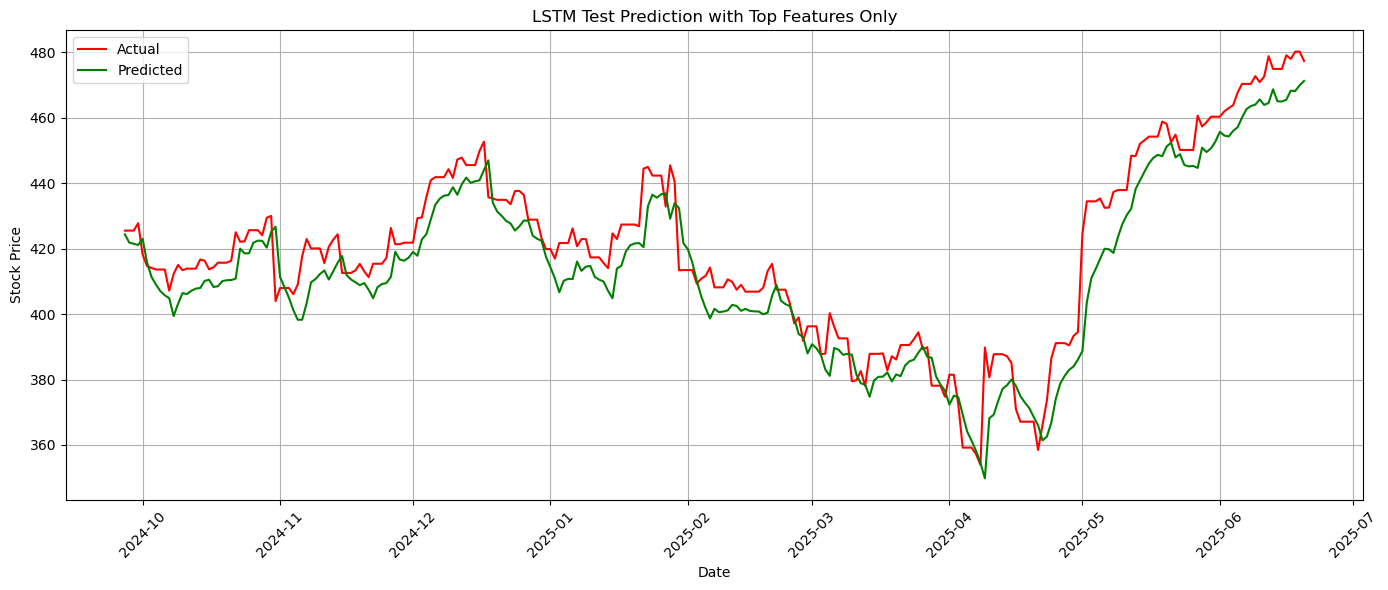

In [187]:
test_dates = imp_feat_df.index[-len(y_test_actual):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label="Actual", color="red")
plt.plot(test_dates, y_test_pred, label="Predicted", color="green")
plt.title("LSTM Test Prediction with Top Features Only")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Observations and Interpretations**

1. The green "Predicted" line tracks the red "Actual" line much more closely than in the previous engineered feature plot. It still exhibits some lag, but it's less pronounced, and the model reacts more appropriately to price changes.

2. The predicted line is less erratic and has fewer extreme overshoots/undershoots compared to the previous overfitted model.

3. Look at the strong rally from early May 2025 onwards. While the model doesn't perfectly capture every peak, it follows the overall upward trajectory much better than before, significantly reducing the underestimation gap seen in the prior plot. The dip around April 2025 is also tracked more reasonably.

By focusing on feature selection, it has successfully tackled the severe overfitting issue. The model now demonstrates a much better ability to generalize to unseen data.

### **Conclusions**

Based on the observations, the LSTM model with feature selection is demonstrably the better performing model among those compared. While traditional ARIMA models and XGBoost largely failed to generalize or capture the complex, non-linear dynamics of stock prices, and ARIMA-GARCH had limitations over longer, more dynamic periods, the LSTM model, specifically after careful feature selection, successfully addressed the critical issue of overfitting. It showed a significantly improved ability to generalize to unseen data, providing much more accurate and less erratic predictions that closely tracked actual price movements, including strong rallies and dips.